<a href="https://colab.research.google.com/github/lizaoh/cognitive_graphs/blob/main/space_fortress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Link](https://andersonlab.net/sf-paper-2017/turning.html) to play game

The goal of the game is to destroy the fortress in the center.
The fortress can't be destroyed if any mines (friend or foe) are present on the screen, so mines that appear must be destroyed.

Data from 9 participants, each with 248 games played (~31 hours total). They played 8 5-minute games per day for 31 days. From [Rahman & Gray, 2020](https://onlinelibrary.wiley.com/doi/epdf/10.1111/tops.12512), participant 7 has the best performance and participant 2 has the worst.

What columns mean from [Destefano & Gray (2016)](https://www.researchgate.net/profile/Wayne-Gray/publication/305960456_Where_Should_Researchers_Look_for_Strategy_Discoveries_during_the_Acquisition_of_Complex_Task_Performance_The_Case_of_Space_Fortress/links/57a776c608ae3f452938edb0/Where-Should-Researchers-Look-for-Strategy-Discoveries-during-the-Acquisition-of-Complex-Task-Performance-The-Case-of-Space-Fortress.pdf) and [Rahman & Gray (2020)](https://onlinelibrary.wiley.com/doi/epdf/10.1111/tops.12512):
* **pnts** -> points; "a measure of several skills
together; such as, skills in fighting the Fortress and the mines, defending own ship, managing resources" (Rahman & Gray, 2020, p. 2)
* **speed** -> "rewards speed of killing mines and penalizes if mines escape"
* **cntrl** -> control; "measures the performers’
control over OS’  (own ship's) spatial location; the player is rewarded at a higher rate for staying within the large hexagon than outside"
* **vlcty** -> velocity; "measures the performers’
control over OS’ velocity; the player is rewarded for flying the ship within a speed limit and penalized for any violations"
* **iff** -> identify if a mine is friend or foe
* **vlner** -> vulnerability; the ship becomes vulnerable by "10 or more hits (at intervals > 400ms)"
* **thrust key** -> pressing moves ship forward
* **shots** -> each player starts with a stock of 100 shots and once they run out, each additional shots results in a 3 point penalty


**Information about the data folder and file structure from the [OSF page](https://osf.io/v5mzx/):**

The dataset was collected by Marc Destefano as a part of his thesis (Destefano, 2010) during his PhD in Cognitive Science from Rensselaer Polytechnic Institute. Due to the enormous richness of the data, it has been studied in several works ([Destefano & Gray, 2016](https://www.researchgate.net/profile/Wayne-Gray/publication/305960456_Where_Should_Researchers_Look_for_Strategy_Discoveries_during_the_Acquisition_of_Complex_Task_Performance_The_Case_of_Space_Fortress/links/57a776c608ae3f452938edb0/Where-Should-Researchers-Look-for-Strategy-Discoveries-during-the-Acquisition-of-Complex-Task-Performance-The-Case-of-Space-Fortress.pdf); [Gray & Lindstedt, 2017](https://onlinelibrary.wiley.com/doi/epdf/10.1111/cogs.12412); [Rahman & Gray, 2020](https://onlinelibrary.wiley.com/doi/epdf/10.1111/tops.12512), focusing on individual performance and learning at many different scopes of the complex task; such as, different levels of task, different timescales, in part- or sub-tasks vs whole task, individual learning curves vs group-averaged learning curves.

These works demonstrate and discuss a lot of details about how these individuals conquer the complex task in their individually brilliant ways. However, even then, there remains a lot of untold stories of individuals' extreme ingenuity, for at least two-thirds (or simply 6) of the 9 nine players.

1. A CSV File (with the prefix "Complete"), containing Game-aggregated measures, at many different levels of performance, for each player in each game.

-- Example measures collected: All five game-generated scores, the lower-level breakdowns (e.g., number of fortress kills, average distance between fortress and ship, number of ship deaths, total number of keypresses -- of different types and with their avg durations of being pressed down -- and more).

-- Each player is labeled by two ids: (1) One 4-digit long student id (sid in dataset) and (2) a one-digit player id (pid in dataset).

-- Games labeled: 1-248
-- Missing (Please see the semi-short note (labeled 2 below): five games played by Player 4 (SID: 2237); Games -- 58, 60, 117, 119, 216

2. The CSV file saved in Pickle Format (Prefix -- Complete, Suffix -- _pickle.txt). Easier to directly load in Python as a Pandas DataFrame.

3. A ZIP file containing Within-game information

-- Collected at 30 Hz over ~5min of each game, therefore, ~9000 samples per game.

-- Information includes: At each point of time, each game object's state, location and actions, each keypress state, each ship action etc. With each event, state information changed to precisely mark the start and the end of event. As player keypresses in our universe translate into actions in game universe, all event information is essentially collected at least twice, and possibly in even more ways.

-- Each player data is separated and labeled (by pid) into Folders/Directories, within which:
-- Each game's data is separated and labeled (by sid) into *.csv files.
GENERAL FORM OF PATH to : /p_--.csv
EXAMPLE: for player 1, with sid = 1133, for day 30, game number 8 -- "1//p1_1133-30-8.csv"
for player 4, with sid = 2237, for day 20, game number 1 -- "4//p4_2237-20-1.csv"

# Top of script

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import re
import math
import networkx as nx
import scipy.stats as stats
from sklearn.decomposition import IncrementalPCA
from time import perf_counter
import warnings
warnings.filterwarnings("ignore")
%cd /content/gdrive/MyDrive/Colab Notebooks/YoshimiLab/cognitive_graphs/scripts/supplemental_scripts
%run custom_draw_labels.ipynb

/content/gdrive/MyDrive/Colab Notebooks/YoshimiLab/cognitive_graphs/scripts/supplemental_scripts


# Functions

In [3]:
def sf_get_subj_info(subjects=None, df=None, grid_res=None):
  # Dictionary for grid width, x edges, and y edges
  all_subj_info = {}

  for s, subj in enumerate(subjects):
    subj_df = df[df['pid'] == subj]
    xcoords = subj_df['PC_1']
    ycoords = subj_df['PC_2']

    min_x = min(xcoords)
    max_x = max(xcoords)
    min_y = min(ycoords)
    max_y = max(ycoords)
    x_bounds = [min_x, max_x]
    y_bounds = [min_y, max_y]
    x_range = max_x - min_x
    y_range = max_y - min_y

    _, x_edges, y_edges = np.histogram2d(xcoords, ycoords, bins=grid_res,
                                          range=[x_bounds, y_bounds])

    all_subj_info[subj] = {}
    all_subj_info[subj]['grid_res'] = grid_res
    all_subj_info[subj]['x_edges'] = x_edges
    all_subj_info[subj]['y_edges'] = y_edges

    min_game = subj_df['overall_game_num'].min()
    max_game = subj_df['overall_game_num'].max()
    early_df = subj_df[subj_df['overall_game_num'] == min_game]
    late_df = subj_df[subj_df['overall_game_num'] == max_game]
    all_subj_info[subj]['first_game'] = min_game
    all_subj_info[subj]['last_game'] = max_game

    early_x_coords = early_df['PC_1']
    early_y_coords = early_df['PC_2']
    late_x_coords = late_df['PC_1']
    late_y_coords = late_df['PC_2']

  return all_subj_info

In [4]:
def sf_get_grid_ids(subjects=None, df=None, grid_res=None, all_subj_info=None):
  # Categorize each coordinate into the grid square it belongs to
  # Implemented code from GPT-4o to make this run much faster (this is our code modified by GPT)
  grid_id = pd.DataFrame()
  all_data = []

  for s, subj in enumerate(subjects):
    subj_df = df[df['pid'] == subj]

    x_edges = all_subj_info[subj]['x_edges']
    y_edges = all_subj_info[subj]['y_edges']

    coords_df = pd.DataFrame()
    games_to_compare = [all_subj_info[subj]['first_game'], all_subj_info[subj]['last_game']]
    for g, game in enumerate(games_to_compare):
      game_df = subj_df[subj_df['overall_game_num'] == game]
      xcoords = np.array(game_df['PC_1'])
      ycoords = np.array(game_df['PC_2'])

      # Makes the grid ids use zero-indexing
      x_ids = np.digitize(xcoords, x_edges, right=False) - 1
      y_ids = np.digitize(ycoords, y_edges, right=False) - 1

      # Ensure no negative indices
      x_ids[x_ids == -1] = 0
      y_ids[y_ids == -1] = 0

      # Ensure indices are within the range [0, grid_width-1]
      x_ids = np.clip(x_ids, 0, grid_res - 1)
      y_ids = np.clip(y_ids, 0, grid_res - 1)

      trial_type = 'early' if g == 0 else 'late'

      data = {
          'subj': subj,
          'grid_res': grid_res,
          'game_num': game,
          'condition': trial_type,
          'x': xcoords,
          'y': ycoords,
          'x_id': x_ids,
          'y_id': y_ids,
          'prev_x': np.roll(xcoords, 1).astype(float),
          'prev_y': np.roll(ycoords, 1).astype(float),
          'prev_x_id': np.roll(x_ids, 1).astype(float),
          'prev_y_id': np.roll(y_ids, 1).astype(float),
      }

      data['prev_x'][0] = np.nan
      data['prev_y'][0] = np.nan
      data['prev_x_id'][0] = np.nan
      data['prev_y_id'][0] = np.nan

      all_data.append(pd.DataFrame(data))

    grid_id = pd.concat(all_data, ignore_index=True)

    grid_id['id_coord'] = grid_id[['x_id', 'y_id']].apply(tuple, axis=1)

  return grid_id

In [5]:
def sf_get_transitions_mat(subjects=None, grid_res=None, grid_id_df=None):
  # Transition count / strength matrix
  # Optimized using our code that was modified by GPT-4o
  # Structure is mat[subj][early or late game][grid size][grid size][grid size][grid size]
  transitions_mat = []
  transitions_mat = np.zeros((len(subjects), 2, grid_res, grid_res, grid_res, grid_res))

  # Checks number of occurrences of each unique coordinate pair then replaces zero entry in transitions_mat
  for s, subj in enumerate(subjects):
    subj_df = grid_id_df[grid_id_df['subj'] == subj]
    for c, condition in enumerate(['early', 'late']):
      condition_df = subj_df.loc[subj_df['condition'] == condition]
      adj_ids = set(zip(condition_df['prev_x_id'], condition_df['prev_y_id'], condition_df['x_id'], condition_df['y_id']))
      for id_tuple in adj_ids:
        # print(id_tuple)
        if not np.isnan(np.array(id_tuple)).any():
          id_arr = [int(x) for x in id_tuple]
          count = len(condition_df.loc[(condition_df['prev_x_id'] == id_arr[0]) & (condition_df['prev_y_id'] == id_arr[1]) & (condition_df['x_id'] == id_arr[2]) & (condition_df['y_id'] == id_arr[3])])
          # count = condition_df.groupby(['prev_x_id', 'prev_y_id', 'x_id', 'y_id']).count()
          # print(count)
          transitions_mat[s][c][id_arr[0]][id_arr[1]][id_arr[2]][id_arr[3]] = count

  return transitions_mat

In [6]:
def sf_get_metrics(subjects=None, transitions_mat=None, grid_res=None):
  # Code optimized using GPT-4o
  results = []

  for s, subj_mat in enumerate(transitions_mat):
    subject_data = {'subject': subjects[s],
                    'grid_res': grid_res}
    for cond, game_mat in zip(['early', 'late'], subj_mat):
      # Finds and lists indices of all nonzero entries in game_mat
      nonzero_indices = np.argwhere(game_mat > 0)
      visited_states = set()
      # fanout_count = []

      # Populates visited states and fan-out count for calculating fan-out avg
      for prev_x, prev_y, x, y in nonzero_indices:
        visited_states.add((prev_x, prev_y))
        visited_states.add((x, y))
        # fanout_count.append(np.count_nonzero(game_mat[prev_x, prev_y]))

      num_states = len(visited_states)
      num_transitions = len(nonzero_indices)
      avg_transition = np.mean(game_mat[game_mat > 0])
      # fanout_avg = np.sum(fanout_count) / num_states if num_states > 0 else 0

      # Compute number of transitions and average transition strength/count
      nonzero_values = game_mat[game_mat != 0]
      num_transitions = len(nonzero_values)
      average_nonzero = np.mean(nonzero_values)

      num_states = len(visited_states)
      # avg_fanout = np.sum(fanout_count) / num_states if num_states > 0 else 0

      subject_data[f'{cond}_num_states'] = num_states
      subject_data[f'{cond}_num_transitions'] = num_transitions
      subject_data[f'{cond}_avg_transition'] = avg_transition
      # subject_data[f'{cond}_fanout_avg'] = fanout_avg

    subject_data['diff_num_states'] = subject_data['early_num_states'] - subject_data['late_num_states']
    subject_data['diff_num_transitions'] = subject_data['early_num_transitions'] - subject_data['late_num_transitions']
    subject_data['diff_avg_transition'] = subject_data['early_avg_transition'] - subject_data['late_avg_transition']
    subject_data['norm_diff_num_states'] = subject_data['diff_num_states'] / grid_res**2
    subject_data['norm_diff_num_transitions'] = subject_data['diff_num_transitions'] / grid_res**2

    results.append(subject_data)

  # Create DataFrame after loop
  avg_transitions_df = pd.DataFrame(results)

  return avg_transitions_df

In [7]:
# Function from GPT-4o to extract folder number, day, and game number for sorting files
def extract_sort_key(file_path):
    folder_name = os.path.basename(os.path.dirname(file_path))
    folder_number = int(folder_name)  # Assumes folder names are integers

    file_name = os.path.basename(file_path)[:-4]
    name_parts = file_name.split('_')

    # Extract day and game number
    day, game_num = map(int, name_parts[1].split('-')[1:])

    return (folder_number, day, game_num)

In [8]:
# Function from GPT-4o to apply PCA on a group in a dataframe
def sf_apply_pca(group, included_columns=[], batch_size=None):
    group = group.reset_index(drop=True)
    # print(group)

    # Perform PCA on participant data
    pca = IncrementalPCA(n_components=2, batch_size=batch_size)
    pca_result = pca.fit_transform(group[included_columns].values)

    # Create a DataFrame with the results
    pca_df = pd.DataFrame(pca_result, columns=[f'PC_{i+1}' for i in range(pca_result.shape[1])])

    # Add the original non-PCA columns back
    result_df = pd.concat([group, pca_df], axis=1)
    return result_df

In [10]:
def plot_markov_chains(subjects=[0], transitions_mat=None, df=None, states=None, all_subj_info=None,
                       wt_add_color=0, wt_mult_color=1, wt_power_color=1,
                       wt_add_width=0, wt_mult_width=1, wt_power_width=1, wt_alpha=1,
                       label_pos=0.5, vertical_alignment='center', horizontal_alignment='center',
                       label_alpha=1, node_size=50, wt_labels=False, unused_nodes_color='#eaeaea',
                       path_nodes_color='#1f77b4', figsize=(15,8), bg_color='white', arc_rad_adj=0.15,
                       arc_rad_across=-0.3, arrow_size=10, font_size=10, alpha_self_loops=1,
                       label_pos_straight_edges=0.6, label_pos_self_loops=0.6,
                       vertical_alignment_straight_edges='top', horizontal_alignment_straight_edges='center',
                       vertical_alignment_self_loops='top', horizontal_alignment_self_loops='right',
                       with_node_labels=False, with_edge_labels=False, show_self_loops=False
                       ):
  avg_transition_probs = pd.DataFrame()
  for (i, num) in subjects:
    subj_mats = transitions_mat[i]
    grid_res = all_subj_info[num]['grid_res']
    states = [(j,i) for i in range(grid_res) for j in range(grid_res)]
    pos = {state: list(state) for state in states}
    num_transitions = []
    num_states = []
    avg_prob = []

    game_labels = ['first', 'last']

    for g, game_mat in enumerate(subj_mats):
      graph = nx.MultiDiGraph()
      edge_labels = {}
      graph.add_nodes_from(states)
      path_nodes = set()

      nonzero_indices = np.argwhere(game_mat > 0)
      nonzero_wts = len(nonzero_indices)

      for prev_x, prev_y, x, y in nonzero_indices:
        transition_count = game_mat[prev_x][prev_y][x][y]
        label = f'{int(transition_count)}'
        start_state = (prev_x, prev_y)
        dest_state = (x, y)
        edge_labels[(start_state, dest_state)] = label
        graph.add_edge(start_state,
                       dest_state,
                       weight=transition_count,
                       label=label
                       )
        path_nodes.add(start_state)
        path_nodes.add(dest_state)

      num_states.append(len(path_nodes))

      # print([(i, j, a['weight']) for (i, j, a) in graph.edges.data() if a['weight'] > 0])
      weights = list(nx.get_edge_attributes(graph, 'weight').values())
      # print(graph.degree(list(graph.nodes)))
      avg_transition = np.sum(weights) / nonzero_wts
      print(f'# of non-zero transition probabilities for trial {game_labels[g]}: {nonzero_wts}')
      print(f'# of states visited for trial {game_labels[g]}: {len(path_nodes)}')
      print(f'Average non-zero transition probability: {avg_transition:.05f}')
      fig, ax = plt.subplots(figsize=figsize)
      # edge_colors = range(len(weights))
      # wts_color = [((w ** wt_power_color) * wt_mult_color) + wt_add_color if w > 0 else w for w in weights]
      # wts_width = [((w ** wt_power_width) * wt_mult_width) + wt_add_width if w > 0 else w for w in weights]
      curved_adj_edges = [(i_coord, j_coord) for (i_coord, j_coord, a) in graph.edges.data()
              if ((j_coord, i_coord) in list(graph.edges()))  # Bidirectional check
              and (i_coord != j_coord)  # No self loops
              and ((abs(i_coord[0] - j_coord[0]) == 1 and i_coord[1] == j_coord[1])  # Horizontal neighbors
                    or (abs(i_coord[1] - j_coord[1]) == 1 and i_coord[0] == j_coord[0])  # Vertical neighbors
                    or (abs(i_coord[0] - j_coord[0]) == 1 and abs(i_coord[1] - j_coord[1]) == 1))]  # Diagonal neighbors

      curved_adj_wts = [a['weight'] for (i_coord, j_coord, a) in graph.edges.data() if (j_coord, i_coord) in list(graph.edges()) and (i_coord != j_coord)]
      curved_across_edges = []
      curved_across_wts = []
      for tup, (i_coord, j_coord, a) in enumerate(list(graph.edges.data())):
        # Checks if x-coordinate of destination state is at least 2 states away from source state but on same y-coordinate
        if ((j_coord[0] > i_coord[0] + 1) or (j_coord[0] < i_coord[0] - 1)) and (j_coord[1] == i_coord[1]):
          curved_across_edges.append((i_coord, j_coord))
          curved_across_wts.append(a['weight'])
        # Checks if y-coordinate of destination state is at least 2 states away from source state but on same x-coordinate
        elif ((j_coord[1] > i_coord[1] + 1) or (j_coord[1] < i_coord[1] - 1))  and (j_coord[0] == i_coord[0]):
          curved_across_edges.append((i_coord, j_coord))
          curved_across_wts.append(a['weight'])
        # Checks if x-coord of source is at least 2 states away from dest but on same y-coord
        elif ((i_coord[0] > j_coord[0] + 1) or (i_coord[0] < j_coord[0] - 1)) and (j_coord[1] == i_coord[1]):
          curved_across_edges.append((i_coord, j_coord))
          curved_across_wts.append(a['weight'])
        # Checks if y-coord of source is at least 2 states away from dest but on same x-coord
        elif ((i_coord[1] > j_coord[1] + 1) or (i_coord[1] < j_coord[1] - 1))  and (j_coord[0] == i_coord[0]):
          curved_across_edges.append((i_coord, j_coord))
          curved_across_wts.append(a['weight'])
      straight_edges = [(i_coord, j_coord) for (i_coord, j_coord, a) in graph.edges.data() if ((i_coord, j_coord) not in curved_adj_edges) and ((i_coord, j_coord) not in curved_across_edges) and (i_coord != j_coord)]
      # print(straight_edges)
      straight_edges_wts = [a['weight'] for (i, j, a) in graph.edges.data() if (i, j) in straight_edges]
      self_loops = list(nx.selfloop_edges(graph, data=False))
      self_loops_wts = [a['weight'] for (i, j, a) in graph.edges.data() if (i, j) in self_loops]
      curved_adj_wts_color = [((w ** wt_power_color) * wt_mult_color) + wt_add_color if w > 0 else w for w in curved_adj_wts]
      curved_across_wts_color = [((w ** wt_power_color) * wt_mult_color) + wt_add_color if w > 0 else w for w in curved_across_wts]
      straight_wts_color = [((w ** wt_power_color) * wt_mult_color) + wt_add_color if w > 0 else w for w in straight_edges_wts]
      self_loops_wts_color = [((w ** wt_power_color) * wt_mult_color) + wt_add_color if w > 0 else w for w in self_loops_wts]

      curved_adj_wts_width = [((w ** wt_power_width) * wt_mult_width) + wt_add_width if w > 0 else w for w in curved_adj_wts]
      curved_across_wts_width = [((w ** wt_power_width) * wt_mult_width) + wt_add_width if w > 0 else w for w in curved_across_wts]
      straight_wts_width = [((w ** wt_power_width) * wt_mult_width) + wt_add_width if w > 0 else w for w in straight_edges_wts]
      self_loops_wts_width = [((w ** wt_power_width) * wt_mult_width) + wt_add_width if w > 0 else w for w in self_loops_wts]

      # Draw vertices and unidirectional edges to neighbors
      nx.draw_networkx(graph,
                      pos,
                      node_size=node_size,
                      node_color=unused_nodes_color,
                      # edge_color=edge_colors,
                      width=straight_wts_width,
                      # edge_cmap=cmap,
                      edgelist=straight_edges,
                      with_labels=with_edge_labels
                      )

      # Draw bidirectional edges when vertices are neighbors
      nx.draw_networkx_edges(graph,
                             pos,
                             node_size=node_size,
                             # edge_color=edge_colors,
                             width=curved_adj_wts_width,
                             # edge_cmap=cmap,
                             edgelist=curved_adj_edges,
                             connectionstyle=f'arc3, rad = {arc_rad_adj}'
                             )

      # Draw edges when vertices are not neighbors
      nx.draw_networkx_edges(graph,
                             pos,
                             node_size=node_size,
                             # edge_color=edge_colors,
                             width=curved_across_wts_width,
                             # edge_cmap=cmap,
                             edgelist=curved_across_edges,
                             connectionstyle=f'arc3, rad = {arc_rad_across}'
                             )

      if show_self_loops:
        # Draw self-directed edges
        nx.draw_networkx_edges(graph,
                              pos,
                              node_size=node_size,
                              # edge_color=edge_colors,
                              width=self_loops_wts_width,
                              # edge_cmap=cmap,
                              edgelist=self_loops,
                              alpha=alpha_self_loops
                              # arrowsize=0,
                              # connectionstyle='arc3, rad = 0'
                              )

      nx.draw_networkx_nodes(graph,
                            pos,
                            nodelist=path_nodes,
                            node_size=node_size,
                            node_color=path_nodes_color
                            )

      # print(edge_weights)


      curved_edge_adj_labels = {(i, j): a['label'] for (i, j, a) in graph.edges.data() if (i, j) in curved_adj_edges}
      curved_edge_across_labels = {(i, j): a['label'] for (i, j, a) in graph.edges.data() if (i, j) in curved_across_edges}
      straight_edge_labels = {(i, j): a['label'] for (i, j, a) in graph.edges.data() if (i, j) in straight_edges}
      self_loops_edge_labels = {(i, j): a['label'] for (i, j, a) in graph.edges.data() if (i, j) in self_loops}

      print(straight_edge_labels)

        # curved_edge_adj_labels = {((i_coord), (j_coord)): edge_labels.get(((i_coord), (j_coord))) for (i_coord, j_coord) in curved_adj_edges}
        # curved_edge_across_labels = {((i_coord), (j_coord)): edge_labels.get(((i_coord), (j_coord))) for (i_coord, j_coord) in curved_across_edges}
        # straight_edge_labels = {((i_coord), (j_coord)): edge_labels.get(((i_coord), (j_coord))) for (i_coord, j_coord) in straight_edges}
        # self_loops_edge_labels = {((i_coord), (j_coord)): edge_labels.get(((i_coord), (j_coord))) for (i_coord, j_coord) in self_loops}

      if wt_labels:
        custom_draw_networkx_edge_labels(graph, pos, edge_labels=curved_edge_adj_labels, rotate=True, rad=arc_rad_adj,
                                          label_pos=label_pos, verticalalignment=vertical_alignment,
                                          horizontalalignment=horizontal_alignment, alpha=label_alpha, font_size=font_size)
        custom_draw_networkx_edge_labels(graph, pos, edge_labels=curved_edge_across_labels, rotate=True, rad=arc_rad_across,
                                          label_pos=label_pos, verticalalignment=vertical_alignment,
                                          horizontalalignment=horizontal_alignment, alpha=label_alpha, font_size=font_size)
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=straight_edge_labels, label_pos=label_pos_straight_edges,
                                    verticalalignment=vertical_alignment_straight_edges, horizontalalignment=horizontal_alignment_straight_edges,
                                    rotate=True, alpha=label_alpha, font_size=font_size)
        if show_self_loops:
          nx.draw_networkx_edge_labels(graph, pos, edge_labels=self_loops_edge_labels, label_pos=label_pos_self_loops,
                                      verticalalignment=vertical_alignment_self_loops, horizontalalignment=horizontal_alignment_self_loops,
                                      rotate=False, alpha=label_alpha, font_size=font_size)

      if df is not None:
        current_trial = game_labels[g]
        game_nums = sorted(df.loc[df['pid'] == num, 'overall_game_num'].unique())

        if current_trial == 'first':
          title_game = min(game_nums)
        elif current_trial == 'last':
          title_game = max(game_nums)
      else:
        title_game = game_labels[g]

      plt.title(f'Participant {num} skill graph for game {title_game}')
      plt.axis('off')
      ax.set_facecolor(bg_color)
      fig.set_facecolor(bg_color)
      plt.show()

# Load Data

More detailed within-game data

Currently only getting .csv files for first and last game per participant because the files are very large.

In [11]:
sf_data_path = "/content/gdrive/MyDrive/Colab Notebooks/YoshimiLab/cognitive_graphs/data/space_fortress/"

In [12]:
few_subj = False
starting_subj = 3
num_addtl_subj = 4

only_first_last = True

if few_subj:
  first_game_files = glob.glob(sf_data_path + f'participant_folders/[{starting_subj}-{starting_subj + num_addtl_subj}]/*_*-1-1.csv')
  last_game_files = glob.glob(sf_data_path + f'participant_folders/[{starting_subj}-{starting_subj + num_addtl_subj}]/*_*-31-8.csv')
else:
  first_game_files = glob.glob(sf_data_path + 'participant_folders/*/*_*-1-1.csv')
  last_game_files = glob.glob(sf_data_path + 'participant_folders/*/*_*-31-8.csv')

all_files = first_game_files + last_game_files

# Sorts files based on pid from folder name, day num, and game num w/i day
sorted_files = sorted(all_files, key=extract_sort_key)

dfs = []

obj_columns = ['ship_alive?', 'mine_alive?', 'fortress_alive?', 'bonus_symbol',
               'iff', 'thrust_key', 'left_key', 'right_key', 'fire_key',
               'iff_key', 'shots_key', 'pnts_key']
dtype_mapping = {col: 'object' for col in obj_columns}

for file in sorted_files:
  # Gets file name without path and ".csv" extension
  file_name = os.path.basename(file)[:-4]
  name_parts = file_name.split('_')
  # Gets player id from file name
  pid = int(name_parts[0][1:])
  # Student id, day number, game number for that day (also from file name)
  sid, day, game_num = map(int, name_parts[1].split('-'))

  game_df = pd.read_csv(file, dtype=dtype_mapping)
  game_df['pid'] = pid
  game_df['sid'] = sid
  game_df['day'] = day
  game_df['day_game_num'] = game_num
  # Overall game number for participant
  game_df['overall_game_num'] = (8 * (day - 1)) + game_num

  # Convert unspecified columns to numeric
  for col in game_df.columns:
      if col not in obj_columns:
          game_df[col] = pd.to_numeric(game_df[col], errors='coerce')

  # This is faster than doing pd.concat() multiple times
  dfs.append(game_df)

within_game_df = pd.concat(dfs, ignore_index=True)

In [13]:
within_game_df.head(5)

system_clock  game_time ship_alive?  ship_x  ship_y  ship_vel_x  \
0  1.226350e+09      25668           y   245.0   315.0         0.0   
1  1.226350e+09      25703           y   245.0   315.0         0.0   
2  1.226350e+09      25737           y   245.0   315.0         0.0   
3  1.226350e+09      25770           y   245.0   315.0         0.0   
4  1.226350e+09      25804           y   245.0   315.0         0.0   

   ship_vel_y  ship_orientation mine_alive?  mine_x  ...   sid day  \
0         0.0              90.0           n     NaN  ...  1133   1   
1         0.0              90.0           n     NaN  ...  1133   1   
2         0.0              90.0           n     NaN  ...  1133   1   
3         0.0              90.0           n     NaN  ...  1133   1   
4         0.0              90.0           n     NaN  ...  1133   1   

   day_game_num overall_game_num  missile3_locx  missile3_locy  missile4_locx  \
0             1                1            NaN            NaN            NaN   
1             1                1            NaN            NaN            NaN   
2             1                1            NaN            NaN            NaN   
3             1                1            NaN            NaN            NaN   
4             1                1            NaN            NaN            NaN   

   missile4_locy missile5_locx  missile5_locy  
0            NaN           NaN            NaN  
1            NaN           NaN            NaN  
2            NaN           NaN            NaN  
3            NaN           NaN            NaN  
4            NaN           NaN            NaN  

[5 rows x 53 columns]

In [15]:
# Check which columns contain 'y' or 'n'
bool_mask = within_game_df.isin(['y', 'n'])
columns_with_y_n = bool_mask.any()
columns_with_y_n_list = columns_with_y_n[columns_with_y_n].index.tolist()

# Convert y/n values to 1/0
within_game_df[columns_with_y_n_list] = within_game_df[columns_with_y_n_list].replace({'n': 0, 'y': 1})

In [16]:
within_game_df.head(5)

system_clock  game_time  ship_alive?  ship_x  ship_y  ship_vel_x  \
0  1.226350e+09      25668            1   245.0   315.0         0.0   
1  1.226350e+09      25703            1   245.0   315.0         0.0   
2  1.226350e+09      25737            1   245.0   315.0         0.0   
3  1.226350e+09      25770            1   245.0   315.0         0.0   
4  1.226350e+09      25804            1   245.0   315.0         0.0   

   ship_vel_y  ship_orientation  mine_alive?  mine_x  ...   sid  day  \
0         0.0              90.0            0     NaN  ...  1133    1   
1         0.0              90.0            0     NaN  ...  1133    1   
2         0.0              90.0            0     NaN  ...  1133    1   
3         0.0              90.0            0     NaN  ...  1133    1   
4         0.0              90.0            0     NaN  ...  1133    1   

   day_game_num overall_game_num  missile3_locx  missile3_locy  missile4_locx  \
0             1                1            NaN            NaN            NaN   
1             1                1            NaN            NaN            NaN   
2             1                1            NaN            NaN            NaN   
3             1                1            NaN            NaN            NaN   
4             1                1            NaN            NaN            NaN   

   missile4_locy missile5_locx  missile5_locy  
0            NaN           NaN            NaN  
1            NaN           NaN            NaN  
2            NaN           NaN            NaN  
3            NaN           NaN            NaN  
4            NaN           NaN            NaN  

[5 rows x 53 columns]

In [ ]:
# within_game_df.to_feather(data_path + 'full_within_game_df.feather')

# PCA on chosen columns

Project down to 2 dimensions

In [17]:
# When the ship, fortress, etc. is not alive/present, there are NaNs for orientation, x, y, etc.
# Excluding rows where ship or fortress not alive
ship_and_fortress_alive_df = within_game_df[(within_game_df['ship_alive?'] == 1) & (within_game_df['fortress_alive?'] == 1)]

In [19]:
ship_and_fortress_alive_df.head(5)

system_clock  game_time  ship_alive?  ship_x  ship_y  ship_vel_x  \
0  1.226350e+09      25668            1   245.0   315.0         0.0   
1  1.226350e+09      25703            1   245.0   315.0         0.0   
2  1.226350e+09      25737            1   245.0   315.0         0.0   
3  1.226350e+09      25770            1   245.0   315.0         0.0   
4  1.226350e+09      25804            1   245.0   315.0         0.0   

   ship_vel_y  ship_orientation  mine_alive?  mine_x  ...   sid  day  \
0         0.0              90.0            0     NaN  ...  1133    1   
1         0.0              90.0            0     NaN  ...  1133    1   
2         0.0              90.0            0     NaN  ...  1133    1   
3         0.0              90.0            0     NaN  ...  1133    1   
4         0.0              90.0            0     NaN  ...  1133    1   

   day_game_num overall_game_num  missile3_locx  missile3_locy  missile4_locx  \
0             1                1            NaN            NaN            NaN   
1             1                1            NaN            NaN            NaN   
2             1                1            NaN            NaN            NaN   
3             1                1            NaN            NaN            NaN   
4             1                1            NaN            NaN            NaN   

   missile4_locy missile5_locx  missile5_locy  
0            NaN           NaN            NaN  
1            NaN           NaN            NaN  
2            NaN           NaN            NaN  
3            NaN           NaN            NaN  
4            NaN           NaN            NaN  

[5 rows x 53 columns]

## Make timesteps equal in first and last game across participants

In [20]:
min_num_timesteps = ship_and_fortress_alive_df.groupby(['pid', 'day_game_num']).count()['system_clock'].min()
game_dfs = []

# Group by participant and game
for (pid, day), group in ship_and_fortress_alive_df.groupby(['pid', 'day_game_num']):
    # print((pid, day, game), group)
    if day == 1:
      game_dfs.append(group.head(min_num_timesteps))
    elif day == 8:
      game_dfs.append(group.tail(min_num_timesteps))

# Concatenate the slices back into one DataFrame
equal_length_df = pd.concat(game_dfs, ignore_index=True)

In [21]:
ship_and_fortress_alive_df.loc[(ship_and_fortress_alive_df['pid'] == 1) &\
 (ship_and_fortress_alive_df['day_game_num'] == 8)].tail(min_num_timesteps).head(5)

system_clock  game_time  ship_alive?   ship_x   ship_y  ship_vel_x  \
8455  1.229119e+09    2219949            1  266.048  240.860       1.671   
8456  1.229119e+09    2219983            1  267.719  240.313       1.671   
8457  1.229119e+09    2220014            1  269.390  239.766       1.671   
8458  1.229119e+09    2220048            1  271.062  239.219       1.671   
8459  1.229119e+09    2220081            1  272.733  238.672       1.671   

      ship_vel_y  ship_orientation  mine_alive?  mine_x  ...   sid  day  \
8455       0.547             318.0            0     NaN  ...  1133   31   
8456       0.547             318.0            0     NaN  ...  1133   31   
8457       0.547             318.0            0     NaN  ...  1133   31   
8458       0.547             318.0            0     NaN  ...  1133   31   
8459       0.547             318.0            0     NaN  ...  1133   31   

      day_game_num overall_game_num  missile3_locx  missile3_locy  \
8455             8              248            NaN            NaN   
8456             8              248            NaN            NaN   
8457             8              248            NaN            NaN   
8458             8              248            NaN            NaN   
8459             8              248            NaN            NaN   

      missile4_locx  missile4_locy missile5_locx  missile5_locy  
8455            NaN            NaN           NaN            NaN  
8456            NaN            NaN           NaN            NaN  
8457            NaN            NaN           NaN            NaN  
8458            NaN            NaN           NaN            NaN  
8459            NaN            NaN           NaN            NaN  

[5 rows x 53 columns]

In [22]:
equal_length_df.loc[(equal_length_df['pid'] == 1) &\
 (equal_length_df['day_game_num'] == 8)].head(5)

system_clock  game_time  ship_alive?   ship_x   ship_y  ship_vel_x  \
7901  1.229119e+09    2219949            1  266.048  240.860       1.671   
7902  1.229119e+09    2219983            1  267.719  240.313       1.671   
7903  1.229119e+09    2220014            1  269.390  239.766       1.671   
7904  1.229119e+09    2220048            1  271.062  239.219       1.671   
7905  1.229119e+09    2220081            1  272.733  238.672       1.671   

      ship_vel_y  ship_orientation  mine_alive?  mine_x  ...   sid  day  \
7901       0.547             318.0            0     NaN  ...  1133   31   
7902       0.547             318.0            0     NaN  ...  1133   31   
7903       0.547             318.0            0     NaN  ...  1133   31   
7904       0.547             318.0            0     NaN  ...  1133   31   
7905       0.547             318.0            0     NaN  ...  1133   31   

      day_game_num overall_game_num  missile3_locx  missile3_locy  \
7901             8              248            NaN            NaN   
7902             8              248            NaN            NaN   
7903             8              248            NaN            NaN   
7904             8              248            NaN            NaN   
7905             8              248            NaN            NaN   

      missile4_locx  missile4_locy missile5_locx  missile5_locy  
7901            NaN            NaN           NaN            NaN  
7902            NaN            NaN           NaN            NaN  
7903            NaN            NaN           NaN            NaN  
7904            NaN            NaN           NaN            NaN  
7905            NaN            NaN           NaN            NaN  

[5 rows x 53 columns]

## Choose columns and run PCA

In [23]:
# Removed columns for mine, missile, and shell loc info bc of NaNs
included_columns = [
                    'ship_x', 'ship_y', 'ship_vel_x', 'ship_vel_y', 'ship_orientation',
                    # 'mine_alive?', 'mine_x', 'mine_y',
                    # 'fortress_alive?', 'fortress_orientation',
                    # 'pnts', 'cntrl', 'vlcty', 'speed',
                    # 'intervl',
                    'vlner', 'shots',
                    'thrust_key', 'left_key', 'right_key', 'fire_key', 'iff_key', 'shots_key', 'pnts_key',
                    # 'missile1_locx', 'missile1_locy', 'missile2_locx', 'missile2_locy', 'missile3_locx',
                    # 'missile3_locy', 'missile4_locx', 'missile4_locy', 'shell1_locx', 'shell1_locy',
                    # 'shell2_locx', 'shell2_locy', 'shell3_locx', 'shell3_locy'
                    ]

batch_size = None
sf_pca_df = equal_length_df.groupby(['pid']).apply(sf_apply_pca, included_columns=included_columns, batch_size=batch_size).reset_index(drop=True)


In [24]:
sf_pca_df.head(5)

system_clock  game_time  ship_alive?  ship_x  ship_y  ship_vel_x  \
0  1.226350e+09      25668            1   245.0   315.0         0.0   
1  1.226350e+09      25703            1   245.0   315.0         0.0   
2  1.226350e+09      25737            1   245.0   315.0         0.0   
3  1.226350e+09      25770            1   245.0   315.0         0.0   
4  1.226350e+09      25804            1   245.0   315.0         0.0   

   ship_vel_y  ship_orientation  mine_alive?  mine_x  ...  day_game_num  \
0         0.0              90.0            0     NaN  ...             1   
1         0.0              90.0            0     NaN  ...             1   
2         0.0              90.0            0     NaN  ...             1   
3         0.0              90.0            0     NaN  ...             1   
4         0.0              90.0            0     NaN  ...             1   

   overall_game_num  missile3_locx missile3_locy  missile4_locx  \
0                 1            NaN           NaN            NaN   
1                 1            NaN           NaN            NaN   
2                 1            NaN           NaN            NaN   
3                 1            NaN           NaN            NaN   
4                 1            NaN           NaN            NaN   

   missile4_locy  missile5_locx  missile5_locy       PC_1       PC_2  
0            NaN            NaN            NaN  68.558365 -94.571779  
1            NaN            NaN            NaN  68.558365 -94.571779  
2            NaN            NaN            NaN  68.558365 -94.571779  
3            NaN            NaN            NaN  68.558365 -94.571779  
4            NaN            NaN            NaN  68.558365 -94.571779  

[5 rows x 55 columns]

## PCA plots comparing first and last games for each participant

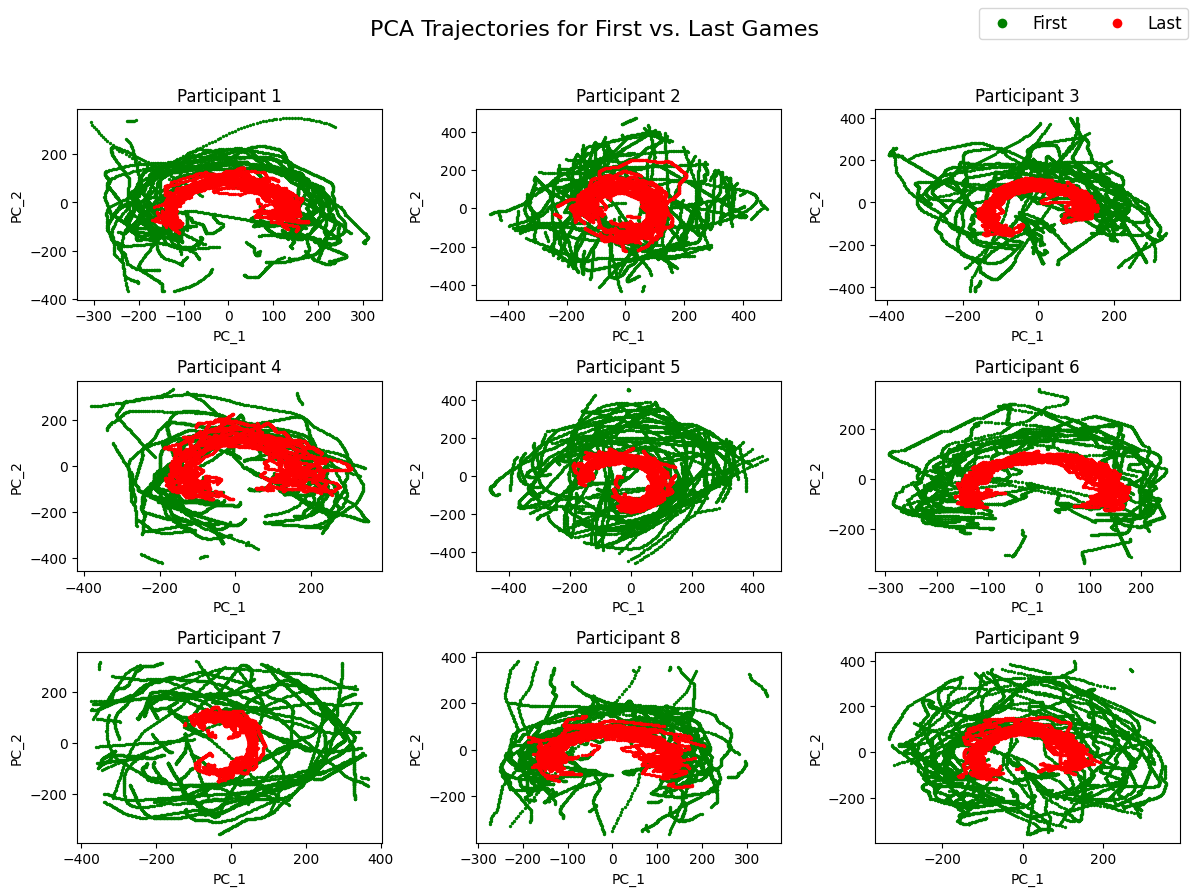

In [28]:
# All subject plots
subjects = sf_pca_df['pid'].unique()
n_subjects = len(subjects)

n_cols = 3
n_rows = int(np.ceil(n_subjects / n_cols))  # Calculate rows
pt_size = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
axs = axs.flatten()  # Flatten for easier iteration

for s, subj in enumerate(subjects):
    subj_df = sf_pca_df[sf_pca_df['pid'] == subj]
    min_game = subj_df['overall_game_num'].min()
    max_game = subj_df['overall_game_num'].max()

    axs[s].scatter(subj_df.loc[subj_df['overall_game_num'] == min_game, 'PC_1'],
                   subj_df.loc[subj_df['overall_game_num'] == min_game, 'PC_2'],
                   s=pt_size,
                   color='g')

    axs[s].scatter(subj_df.loc[subj_df['overall_game_num'] == max_game, 'PC_1'],
                   subj_df.loc[subj_df['overall_game_num'] == max_game, 'PC_2'],
                   s=pt_size,
                   color='r')

    axs[s].set_title(f'Participant {subj}')
    axs[s].set_xlabel('PC_1')
    axs[s].set_ylabel('PC_2')

# Remove empty subplots if any (not needed in this case but useful for generalization)
for i in range(s + 1, len(axs)):
    fig.delaxes(axs[i])

fig.suptitle('PCA Trajectories for First vs. Last Games', fontsize=16)
colors = {'First': 'g', 'Last': 'r'}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=8, label=label)
                  for label in colors]
fig.legend(handles=legend_handles, loc='upper right', ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Coarse graining on ship coords

Currently comparing first and last game for each participant in entire experiment

## Grid width

In [29]:
set_grid_res = True
# Create 20x20 coarse-grained states grid on pca plots
grid_res = 20

In [30]:
sf_subjects = sf_pca_df['pid'].unique()
sf_all_subj_info = sf_get_subj_info(sf_subjects, sf_pca_df, grid_res)

## Create transition count/strength matrix

In [31]:
sf_grid_id = sf_get_grid_ids(sf_subjects, sf_pca_df, grid_res, sf_all_subj_info)

In [33]:
sf_grid_id.head(5)

subj  grid_res  game_num condition          x          y  x_id  y_id  \
0     1        20         1     early  68.558365 -94.571779    12     7   
1     1        20         1     early  68.558365 -94.571779    12     7   
2     1        20         1     early  68.558365 -94.571779    12     7   
3     1        20         1     early  68.558365 -94.571779    12     7   
4     1        20         1     early  68.558365 -94.571779    12     7   

      prev_x     prev_y  prev_x_id  prev_y_id id_coord  
0        NaN        NaN        NaN        NaN  (12, 7)  
1  68.558365 -94.571779       12.0        7.0  (12, 7)  
2  68.558365 -94.571779       12.0        7.0  (12, 7)  
3  68.558365 -94.571779       12.0        7.0  (12, 7)  
4  68.558365 -94.571779       12.0        7.0  (12, 7)

In [34]:
sf_transitions_mat = sf_get_transitions_mat(sf_subjects, grid_res, sf_grid_id)

## Difference in states visited and number of transitions

In [35]:
sf_metrics_df = sf_get_metrics(sf_subjects, sf_transitions_mat, grid_res)

In [36]:
sf_metrics_df.head(5)

subject  grid_res  early_num_states  early_num_transitions  \
0        1        20               246                    753   
1        2        20               235                    836   
2        3        20               243                    784   
3        4        20               255                    709   
4        5        20               247                    893   

   early_avg_transition  late_num_states  late_num_transitions  \
0             10.491368               60                   215   
1              9.449761               74                   224   
2             10.076531               45                   147   
3             11.142454               95                   324   
4              8.846585               48                   161   

   late_avg_transition  diff_num_states  diff_num_transitions  \
0            36.744186              186                   538   
1            35.267857              161                   612   
2            53.741497              198                   637   
3            24.382716              160                   385   
4            49.068323              199                   732   

   diff_avg_transition  norm_diff_num_states  norm_diff_num_transitions  
0           -26.252818                0.4650                     1.3450  
1           -25.818096                0.4025                     1.5300  
2           -43.664966                0.4950                     1.5925  
3           -13.240262                0.4000                     0.9625  
4           -40.221738                0.4975                     1.8300

# Stats

### States

In [38]:
sf_metrics_df['avg_diff_states'] = sf_metrics_df['early_num_states'] - sf_metrics_df['late_num_states']

#### Stat summary

In [39]:
mean_diff = np.mean(sf_metrics_df['avg_diff_states'])
std_diff = np.std(sf_metrics_df['avg_diff_states'], ddof=1)

t_stat, p_val = stats.ttest_rel(sf_metrics_df['early_num_states'], sf_metrics_df['late_num_states'])

deg_of_freedom = len(sf_metrics_df['early_num_states']) - 1

conf_level = 0.95
alpha = 1 - conf_level
crit_value = stats.t.ppf(1 - alpha / 2, deg_of_freedom)
margin_error = crit_value * (std_diff / np.sqrt(len(sf_metrics_df['avg_diff_states'])))
conf_interval = [mean_diff - margin_error, mean_diff + margin_error]

cohen_d = mean_diff / std_diff

print(f"Early: {np.mean(sf_metrics_df['early_num_states'])}")
print(f"Late: {np.mean(sf_metrics_df['late_num_states'])}")
print(f"Mean difference: {mean_diff}")
print(f"Standard error of the mean: {std_diff}")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")
print(f"95% Confidence Interval: {conf_interval}")
print(f"Cohen's d: {cohen_d}")

Early: 262.0
Late: 62.333333333333336
Mean difference: 199.66666666666666
Standard error of the mean: 40.690908075391974
t-statistic: 14.720733164523503
p-value: 4.4574483650118647e-07
95% Confidence Interval: [np.float64(168.38886590431116), np.float64(230.94446742902215)]
Cohen's d: 4.906911054841169


In [40]:
sf_metrics_df['avg_diff_states'].describe()

count      9.000000
mean     199.666667
std       40.690908
min      160.000000
25%      178.000000
50%      186.000000
75%      199.000000
max      286.000000
Name: avg_diff_states, dtype: float64

In [41]:
sf_metrics_df['early_num_states'].describe()

count      9.00000
mean     262.00000
std       31.32491
min      235.00000
25%      245.00000
50%      247.00000
75%      256.00000
max      325.00000
Name: early_num_states, dtype: float64

In [42]:
sf_metrics_df['late_num_states'].describe()

count     9.000000
mean     62.333333
std      17.734148
min      39.000000
25%      48.000000
50%      60.000000
75%      74.000000
max      95.000000
Name: late_num_states, dtype: float64

### State transitions

In [43]:
sf_metrics_df['avg_diff_transitions'] = sf_metrics_df['early_num_transitions'] - sf_metrics_df['late_num_transitions']

#### Stat summary

In [44]:
mean_diff = np.mean(sf_metrics_df['avg_diff_transitions'])
std_diff = np.std(sf_metrics_df['avg_diff_transitions'], ddof=1)

t_stat, p_val = stats.ttest_rel(sf_metrics_df['early_num_transitions'], sf_metrics_df['late_num_transitions'])

deg_of_freedom = len(sf_metrics_df['early_num_transitions']) - 1

conf_level = 0.95
alpha = 1 - conf_level
crit_value = stats.t.ppf(1 - alpha / 2, deg_of_freedom)
margin_error = crit_value * (std_diff / np.sqrt(len(sf_metrics_df['avg_diff_transitions'])))
conf_interval = [mean_diff - margin_error, mean_diff + margin_error]

cohen_d = mean_diff / std_diff

print(f"Early: {np.mean(sf_metrics_df['early_num_transitions'])}")
print(f"Late: {np.mean(sf_metrics_df['late_num_transitions'])}")
print(f"Mean difference: {mean_diff}")
print(f"Standard error of the mean: {std_diff}")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")
print(f"95% Confidence Interval: {conf_interval}")
print(f"Cohen's d: {cohen_d}")

Early: 837.5555555555555
Late: 210.44444444444446
Mean difference: 627.1111111111111
Standard error of the mean: 157.0321976892354
t-statistic: 11.980557879324
p-value: 2.1705206074928416e-06
95% Confidence Interval: [np.float64(506.4054787005861), np.float64(747.816743521636)]
Cohen's d: 3.993519293108


In [45]:
sf_metrics_df['avg_diff_transitions'].describe()

count      9.000000
mean     627.111111
std      157.032198
min      385.000000
25%      538.000000
50%      612.000000
75%      732.000000
max      870.000000
Name: avg_diff_transitions, dtype: float64

In [46]:
sf_metrics_df['early_num_transitions'].describe()

count       9.000000
mean      837.555556
std       112.298832
min       709.000000
25%       755.000000
50%       784.000000
75%       893.000000
max      1031.000000
Name: early_num_transitions, dtype: float64

In [47]:
sf_metrics_df['late_num_transitions'].describe()

count      9.000000
mean     210.444444
std       64.687926
min      123.000000
25%      161.000000
50%      210.000000
75%      224.000000
max      324.000000
Name: late_num_transitions, dtype: float64

### Average transition count / strength

In [48]:
sf_metrics_df['avg_diff_avg_strength'] = sf_metrics_df['early_avg_transition'] - sf_metrics_df['late_avg_transition']

#### Stat summary

In [49]:
mean_diff = np.mean(sf_metrics_df['avg_diff_avg_strength'])
std_diff = np.std(sf_metrics_df['avg_diff_avg_strength'], ddof=1)

t_stat, p_val = stats.ttest_rel(sf_metrics_df['early_avg_transition'], sf_metrics_df['late_avg_transition'])

deg_of_freedom = len(sf_metrics_df['early_avg_transition']) - 1

conf_level = 0.95
alpha = 1 - conf_level
crit_value = stats.t.ppf(1 - alpha / 2, deg_of_freedom)
margin_error = crit_value * (std_diff / np.sqrt(len(sf_metrics_df['avg_diff_avg_strength'])))
conf_interval = [mean_diff - margin_error, mean_diff + margin_error]

cohen_d = mean_diff / std_diff

print(f"Early: {np.mean(sf_metrics_df['early_avg_transition'])}")
print(f"Late: {np.mean(sf_metrics_df['late_avg_transition'])}")
print(f"Mean difference: {mean_diff}")
print(f"Standard error of the mean: {std_diff}")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")
print(f"95% Confidence Interval: {conf_interval}")
print(f"Cohen's d: {cohen_d}")

Early: 9.57388424160848
Late: 40.85448793774453
Mean difference: -31.280603696136055
Standard error of the mean: 13.429294974761694
t-statistic: -6.9878434619814005
p-value: 0.00011401450081731307
95% Confidence Interval: [np.float64(-41.603273611028385), np.float64(-20.957933781243725)]
Cohen's d: -2.3292811539938


In [50]:
sf_metrics_df['avg_diff_avg_strength'].describe()

count     9.000000
mean    -31.280604
std      13.429295
min     -56.271952
25%     -40.221738
50%     -28.839906
75%     -25.818096
max     -13.240262
Name: avg_diff_avg_strength, dtype: float64

In [51]:
sf_metrics_df['early_avg_transition'].describe()

count     9.000000
mean      9.573884
std       1.194545
min       7.662464
25%       8.846585
50%      10.076531
75%      10.463576
max      11.142454
Name: early_avg_transition, dtype: float64

In [52]:
sf_metrics_df['late_avg_transition'].describe()

count     9.000000
mean     40.854488
std      12.722537
min      24.382716
25%      35.267857
50%      37.619048
75%      49.068323
max      64.227642
Name: late_avg_transition, dtype: float64

# Cognitive graphs

# of non-zero transition probabilities for trial first: 753
# of states visited for trial first: 246
Average non-zero transition probability: 10.49137
{((2, 0), (np.int64(0), np.int64(19))): '1', ((5, 0), (np.int64(2), np.int64(19))): '1', ((6, 0), (np.int64(7), np.int64(0))): '1', ((7, 0), (np.int64(7), np.int64(1))): '1', ((2, 1), (np.int64(2), np.int64(0))): '1', ((2, 1), (np.int64(3), np.int64(1))): '1', ((4, 1), (np.int64(5), np.int64(1))): '1', ((5, 1), (np.int64(5), np.int64(0))): '1', ((7, 1), (np.int64(8), np.int64(1))): '1', ((8, 1), (np.int64(8), np.int64(2))): '1', ((11, 1), (np.int64(12), np.int64(1))): '1', ((12, 1), (np.int64(12), np.int64(2))): '1', ((2, 2), (np.int64(2), np.int64(1))): '2', ((2, 2), (np.int64(3), np.int64(2))): '1', ((3, 2), (np.int64(4), np.int64(2))): '2', ((4, 2), (np.int64(4), np.int64(1))): '1', ((4, 2), (np.int64(12), np.int64(3))): '1', ((6, 2), (np.int64(6), np.int64(3))): '1', ((8, 2), (np.int64(16), np.int64(3))): '1', ((12, 2), (np.int64(12)

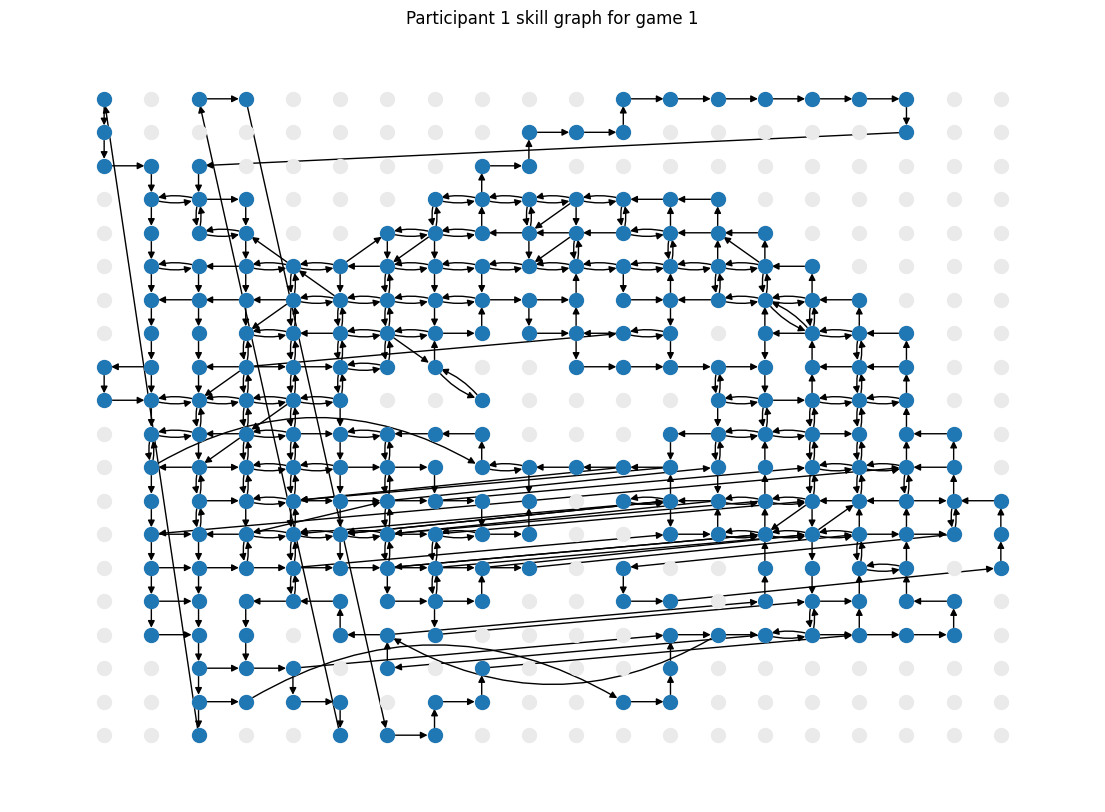

# of non-zero transition probabilities for trial last: 215
# of states visited for trial last: 60
Average non-zero transition probability: 36.74419
{((6, 6), (np.int64(6), np.int64(7))): '1', ((5, 7), (np.int64(5), np.int64(8))): '12', ((5, 7), (np.int64(6), np.int64(8))): '1', ((6, 7), (np.int64(5), np.int64(8))): '1', ((6, 7), (np.int64(6), np.int64(8))): '2', ((13, 7), (np.int64(6), np.int64(6))): '1', ((4, 8), (np.int64(4), np.int64(9))): '1', ((5, 8), (np.int64(5), np.int64(9))): '19', ((6, 8), (np.int64(6), np.int64(9))): '2', ((12, 8), (np.int64(5), np.int64(7))): '1', ((13, 8), (np.int64(5), np.int64(7))): '3', ((13, 8), (np.int64(6), np.int64(7))): '7', ((13, 8), (np.int64(13), np.int64(7))): '1', ((14, 8), (np.int64(6), np.int64(7))): '3', ((4, 9), (np.int64(5), np.int64(10))): '1', ((4, 9), (np.int64(12), np.int64(10))): '1', ((5, 9), (np.int64(5), np.int64(10))): '12', ((5, 9), (np.int64(6), np.int64(10))): '1', ((6, 9), (np.int64(6), np.int64(10))): '8', ((12, 9), (np.int6

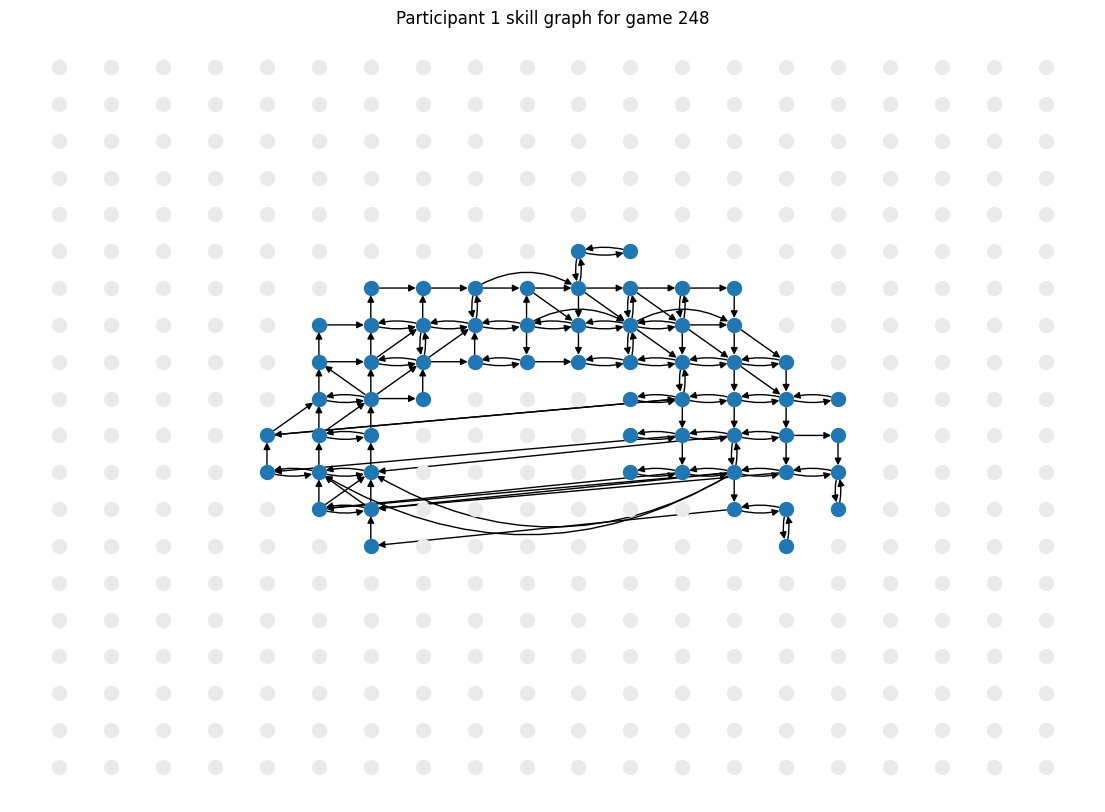

# of non-zero transition probabilities for trial first: 836
# of states visited for trial first: 235
Average non-zero transition probability: 9.44976
{((7, 0), (np.int64(8), np.int64(0))): '1', ((8, 0), (np.int64(8), np.int64(1))): '1', ((9, 0), (np.int64(9), np.int64(1))): '1', ((10, 0), (np.int64(2), np.int64(9))): '1', ((11, 0), (np.int64(10), np.int64(0))): '1', ((7, 1), (np.int64(7), np.int64(2))): '1', ((8, 1), (np.int64(8), np.int64(2))): '2', ((9, 1), (np.int64(8), np.int64(1))): '1', ((10, 1), (np.int64(10), np.int64(2))): '1', ((11, 1), (np.int64(11), np.int64(2))): '1', ((5, 2), (np.int64(16), np.int64(13))): '1', ((6, 2), (np.int64(17), np.int64(13))): '2', ((7, 2), (np.int64(6), np.int64(2))): '1', ((7, 2), (np.int64(7), np.int64(3))): '1', ((8, 2), (np.int64(7), np.int64(2))): '1', ((9, 2), (np.int64(11), np.int64(0))): '1', ((10, 2), (np.int64(9), np.int64(2))): '1', ((11, 2), (np.int64(11), np.int64(3))): '1', ((12, 2), (np.int64(12), np.int64(3))): '1', ((13, 2), (np.i

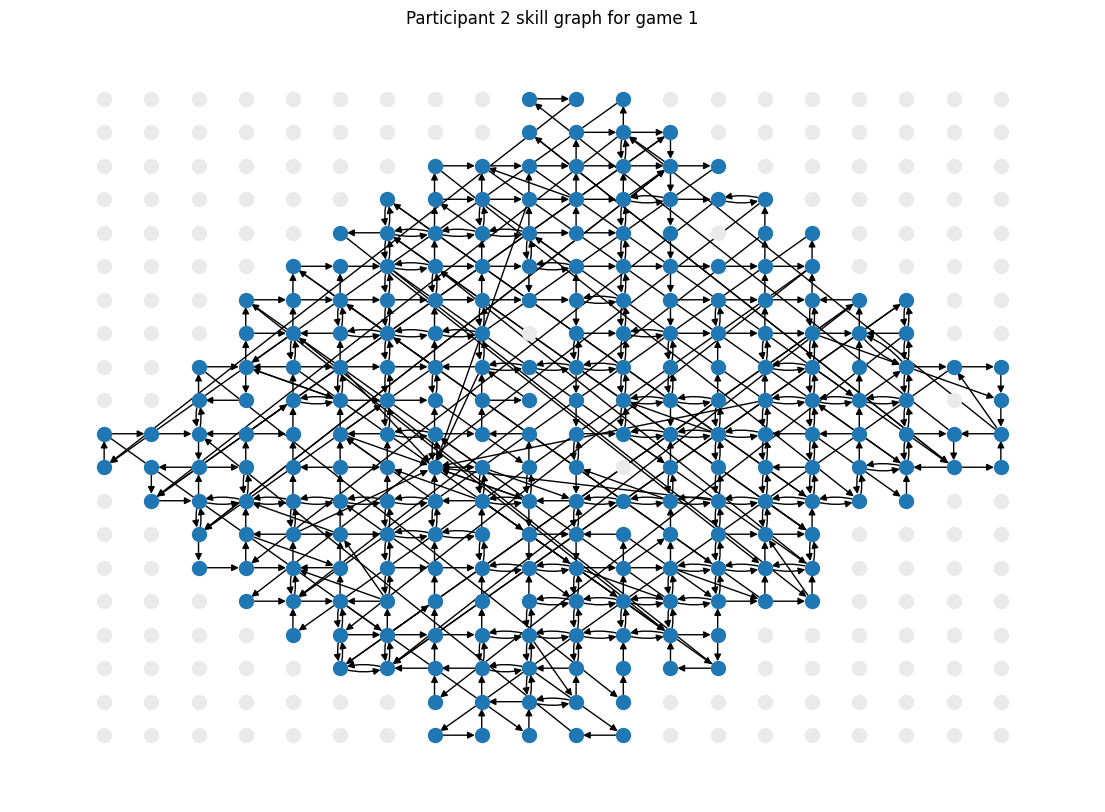

# of non-zero transition probabilities for trial last: 224
# of states visited for trial last: 74
Average non-zero transition probability: 35.26786
{((9, 4), (np.int64(8), np.int64(5))): '1', ((10, 4), (np.int64(10), np.int64(5))): '1', ((8, 5), (np.int64(9), np.int64(5))): '1', ((9, 5), (np.int64(9), np.int64(4))): '1', ((9, 5), (np.int64(10), np.int64(5))): '3', ((10, 5), (np.int64(9), np.int64(6))): '1', ((10, 5), (np.int64(11), np.int64(5))): '1', ((11, 5), (np.int64(11), np.int64(6))): '2', ((7, 6), (np.int64(8), np.int64(6))): '2', ((8, 6), (np.int64(10), np.int64(4))): '1', ((9, 6), (np.int64(9), np.int64(5))): '3', ((9, 6), (np.int64(10), np.int64(6))): '8', ((10, 6), (np.int64(11), np.int64(6))): '8', ((11, 6), (np.int64(11), np.int64(7))): '8', ((11, 6), (np.int64(12), np.int64(6))): '2', ((12, 6), (np.int64(12), np.int64(7))): '2', ((6, 7), (np.int64(7), np.int64(7))): '1', ((6, 7), (np.int64(8), np.int64(6))): '1', ((7, 7), (np.int64(7), np.int64(6))): '1', ((7, 7), (np.int

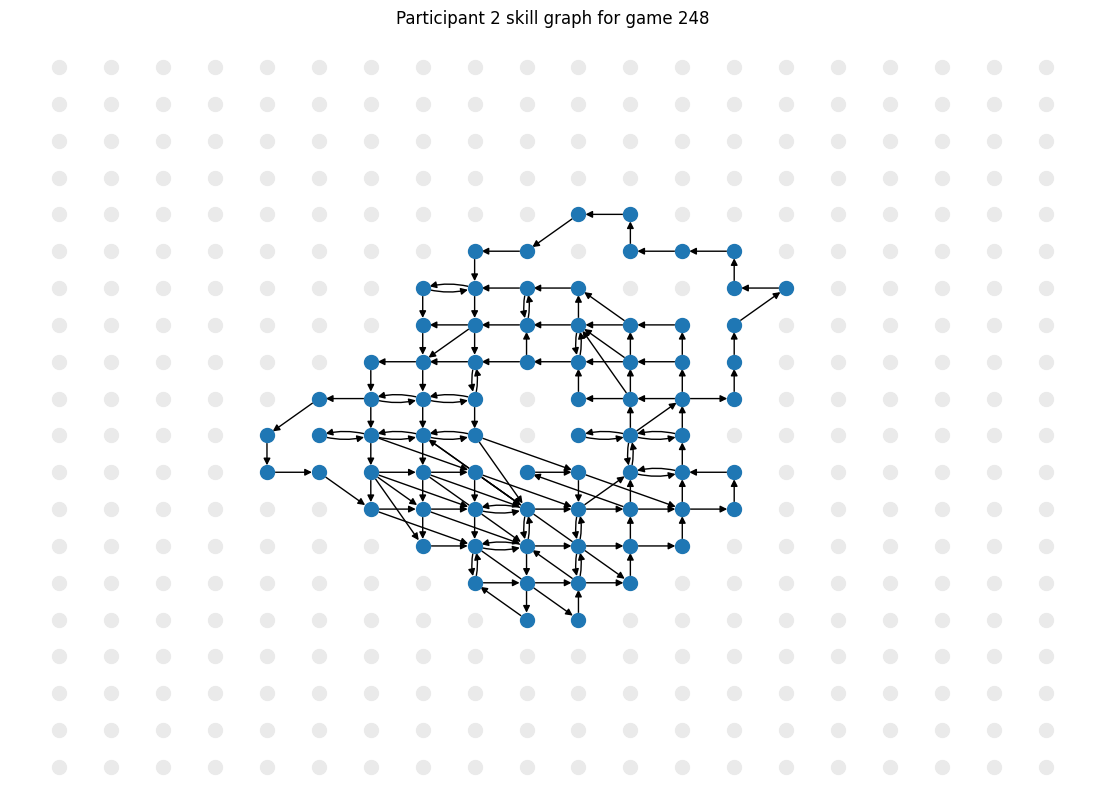

# of non-zero transition probabilities for trial first: 784
# of states visited for trial first: 243
Average non-zero transition probability: 10.07653
{((5, 0), (np.int64(0), np.int64(16))): '1', ((6, 0), (np.int64(0), np.int64(16))): '1', ((5, 1), (np.int64(5), np.int64(0))): '1', ((6, 1), (np.int64(5), np.int64(1))): '1', ((6, 1), (np.int64(6), np.int64(0))): '1', ((7, 1), (np.int64(6), np.int64(1))): '1', ((8, 1), (np.int64(7), np.int64(1))): '1', ((5, 2), (np.int64(18), np.int64(5))): '1', ((8, 2), (np.int64(8), np.int64(1))): '1', ((16, 2), (np.int64(10), np.int64(19))): '1', ((17, 2), (np.int64(11), np.int64(19))): '1', ((5, 3), (np.int64(5), np.int64(2))): '1', ((6, 3), (np.int64(19), np.int64(6))): '1', ((7, 3), (np.int64(8), np.int64(3))): '1', ((8, 3), (np.int64(8), np.int64(2))): '1', ((8, 3), (np.int64(8), np.int64(4))): '1', ((9, 3), (np.int64(8), np.int64(3))): '1', ((10, 3), (np.int64(10), np.int64(4))): '1', ((12, 3), (np.int64(6), np.int64(1))): '1', ((16, 3), (np.int6

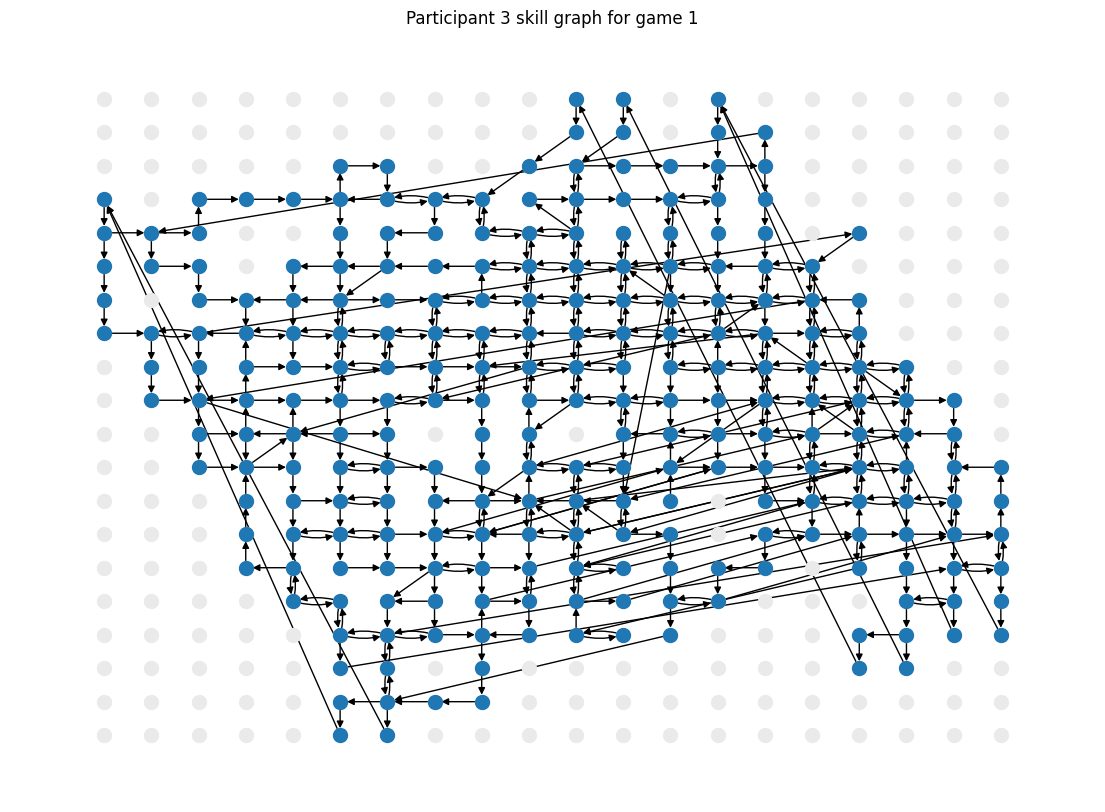

# of non-zero transition probabilities for trial last: 147
# of states visited for trial last: 45
Average non-zero transition probability: 53.74150
{((7, 6), (np.int64(7), np.int64(7))): '7', ((7, 6), (np.int64(8), np.int64(7))): '1', ((8, 6), (np.int64(13), np.int64(8))): '1', ((9, 6), (np.int64(8), np.int64(6))): '1', ((6, 7), (np.int64(6), np.int64(8))): '3', ((7, 7), (np.int64(7), np.int64(8))): '15', ((8, 7), (np.int64(8), np.int64(6))): '1', ((9, 7), (np.int64(9), np.int64(6))): '1', ((9, 7), (np.int64(14), np.int64(9))): '1', ((12, 7), (np.int64(12), np.int64(8))): '1', ((6, 8), (np.int64(6), np.int64(9))): '9', ((7, 8), (np.int64(7), np.int64(9))): '9', ((12, 8), (np.int64(12), np.int64(9))): '1', ((13, 8), (np.int64(7), np.int64(7))): '1', ((13, 8), (np.int64(8), np.int64(6))): '5', ((14, 8), (np.int64(8), np.int64(6))): '2', ((14, 8), (np.int64(8), np.int64(7))): '2', ((6, 9), (np.int64(6), np.int64(10))): '2', ((7, 9), (np.int64(7), np.int64(10))): '15', ((7, 9), (np.int64(8

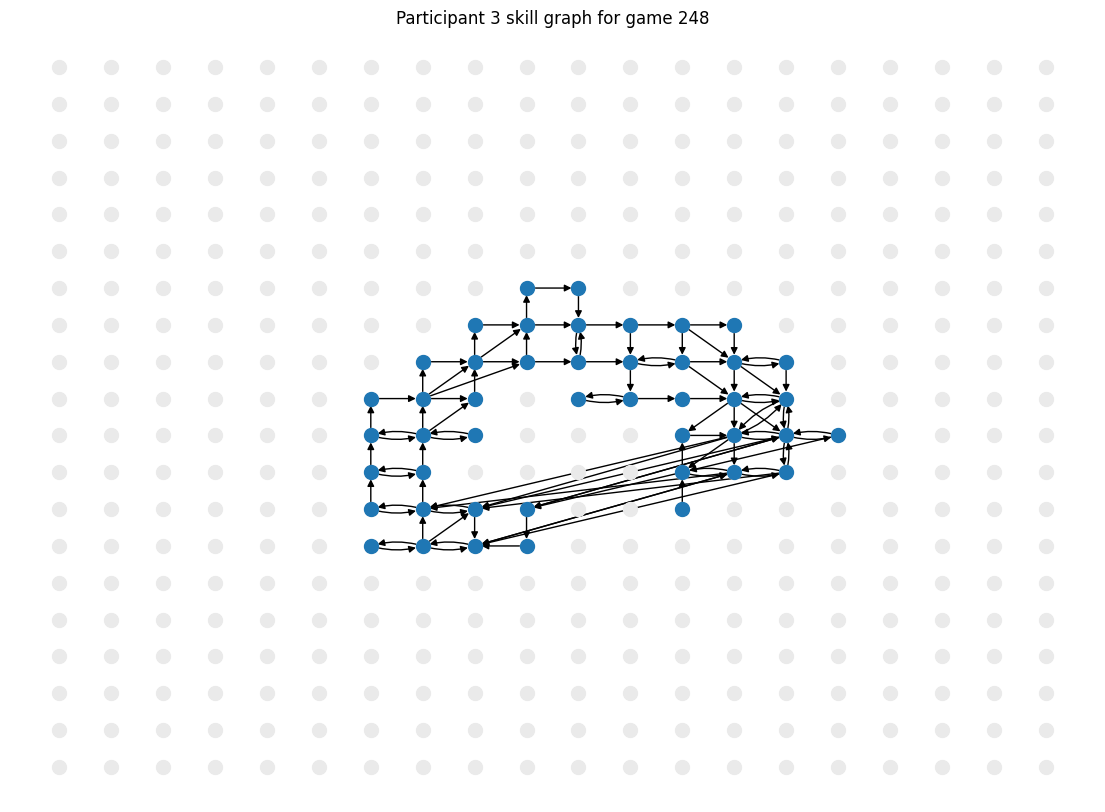

# of non-zero transition probabilities for trial first: 709
# of states visited for trial first: 255
Average non-zero transition probability: 11.14245
{((3, 0), (np.int64(3), np.int64(1))): '1', ((4, 0), (np.int64(3), np.int64(0))): '1', ((5, 0), (np.int64(4), np.int64(0))): '1', ((7, 0), (np.int64(8), np.int64(0))): '1', ((8, 0), (np.int64(3), np.int64(18))): '1', ((3, 1), (np.int64(17), np.int64(5))): '1', ((11, 1), (np.int64(5), np.int64(19))): '1', ((11, 1), (np.int64(12), np.int64(1))): '1', ((12, 1), (np.int64(6), np.int64(19))): '1', ((7, 2), (np.int64(7), np.int64(3))): '1', ((8, 2), (np.int64(7), np.int64(2))): '1', ((9, 2), (np.int64(8), np.int64(2))): '1', ((10, 2), (np.int64(11), np.int64(2))): '1', ((11, 2), (np.int64(11), np.int64(1))): '2', ((3, 3), (np.int64(3), np.int64(4))): '1', ((3, 3), (np.int64(17), np.int64(7))): '1', ((4, 3), (np.int64(3), np.int64(3))): '1', ((4, 3), (np.int64(4), np.int64(4))): '1', ((5, 3), (np.int64(4), np.int64(3))): '2', ((6, 3), (np.int64

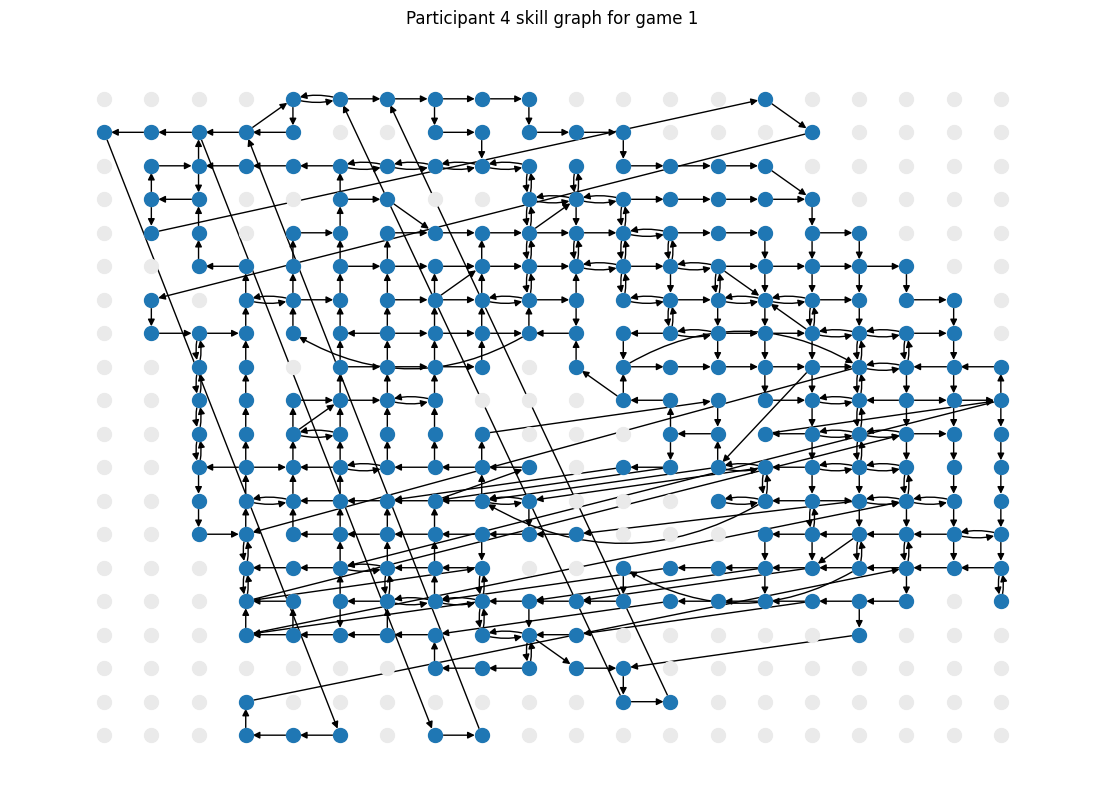

# of non-zero transition probabilities for trial last: 324
# of states visited for trial last: 95
Average non-zero transition probability: 24.38272
{((6, 7), (np.int64(6), np.int64(8))): '3', ((7, 7), (np.int64(6), np.int64(7))): '3', ((7, 7), (np.int64(7), np.int64(8))): '2', ((7, 7), (np.int64(13), np.int64(8))): '1', ((8, 7), (np.int64(7), np.int64(7))): '5', ((9, 7), (np.int64(8), np.int64(7))): '1', ((9, 7), (np.int64(14), np.int64(8))): '1', ((10, 7), (np.int64(9), np.int64(7))): '1', ((17, 7), (np.int64(16), np.int64(8))): '1', ((5, 8), (np.int64(5), np.int64(9))): '4', ((6, 8), (np.int64(6), np.int64(9))): '2', ((7, 8), (np.int64(6), np.int64(8))): '3', ((7, 8), (np.int64(7), np.int64(9))): '7', ((7, 8), (np.int64(8), np.int64(9))): '1', ((8, 8), (np.int64(14), np.int64(9))): '1', ((9, 8), (np.int64(8), np.int64(8))): '1', ((12, 8), (np.int64(7), np.int64(7))): '1', ((12, 8), (np.int64(12), np.int64(9))): '1', ((13, 8), (np.int64(8), np.int64(7))): '4', ((14, 8), (np.int64(13),

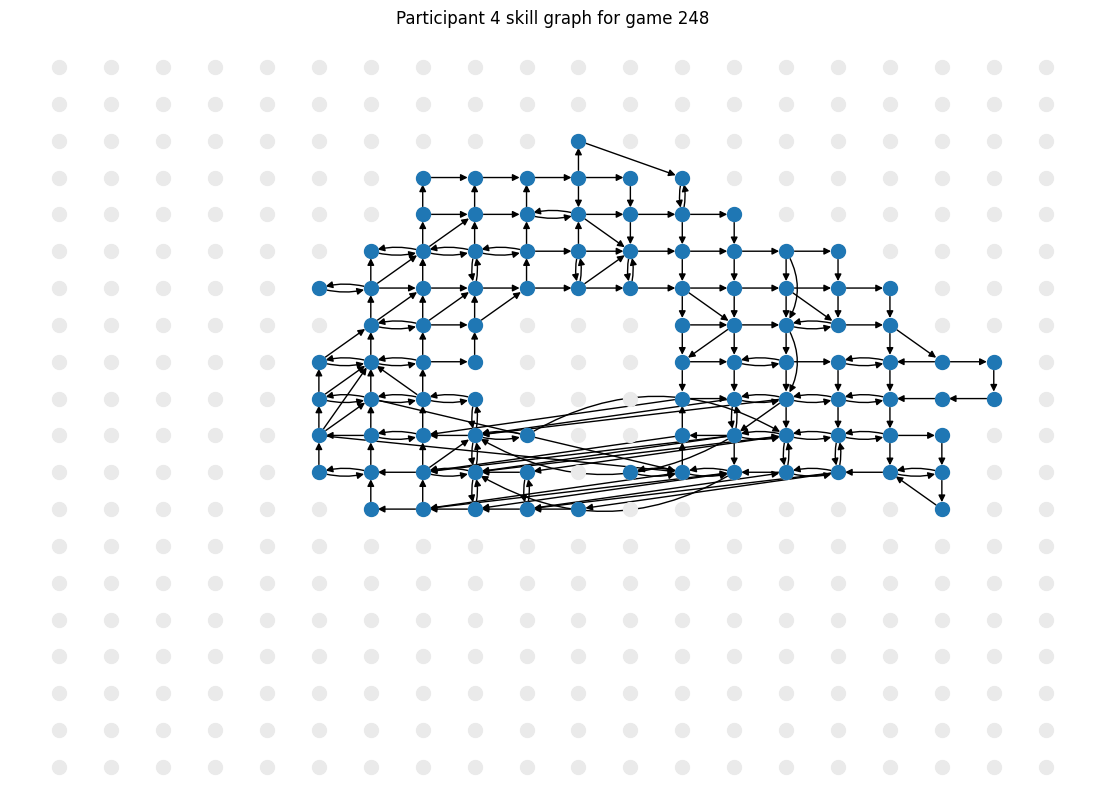

# of non-zero transition probabilities for trial first: 893
# of states visited for trial first: 247
Average non-zero transition probability: 8.84658
{((9, 0), (np.int64(19), np.int64(12))): '1', ((10, 0), (np.int64(9), np.int64(0))): '1', ((10, 0), (np.int64(19), np.int64(11))): '1', ((11, 0), (np.int64(10), np.int64(0))): '1', ((7, 1), (np.int64(7), np.int64(2))): '1', ((7, 1), (np.int64(17), np.int64(13))): '1', ((8, 1), (np.int64(7), np.int64(1))): '1', ((8, 1), (np.int64(7), np.int64(2))): '1', ((8, 1), (np.int64(18), np.int64(13))): '1', ((9, 1), (np.int64(8), np.int64(1))): '1', ((9, 1), (np.int64(18), np.int64(13))): '1', ((10, 1), (np.int64(9), np.int64(1))): '1', ((10, 1), (np.int64(10), np.int64(0))): '1', ((11, 1), (np.int64(10), np.int64(1))): '2', ((11, 1), (np.int64(11), np.int64(0))): '1', ((12, 1), (np.int64(11), np.int64(1))): '1', ((6, 2), (np.int64(15), np.int64(15))): '1', ((6, 2), (np.int64(16), np.int64(14))): '1', ((7, 2), (np.int64(6), np.int64(2))): '1', ((7, 

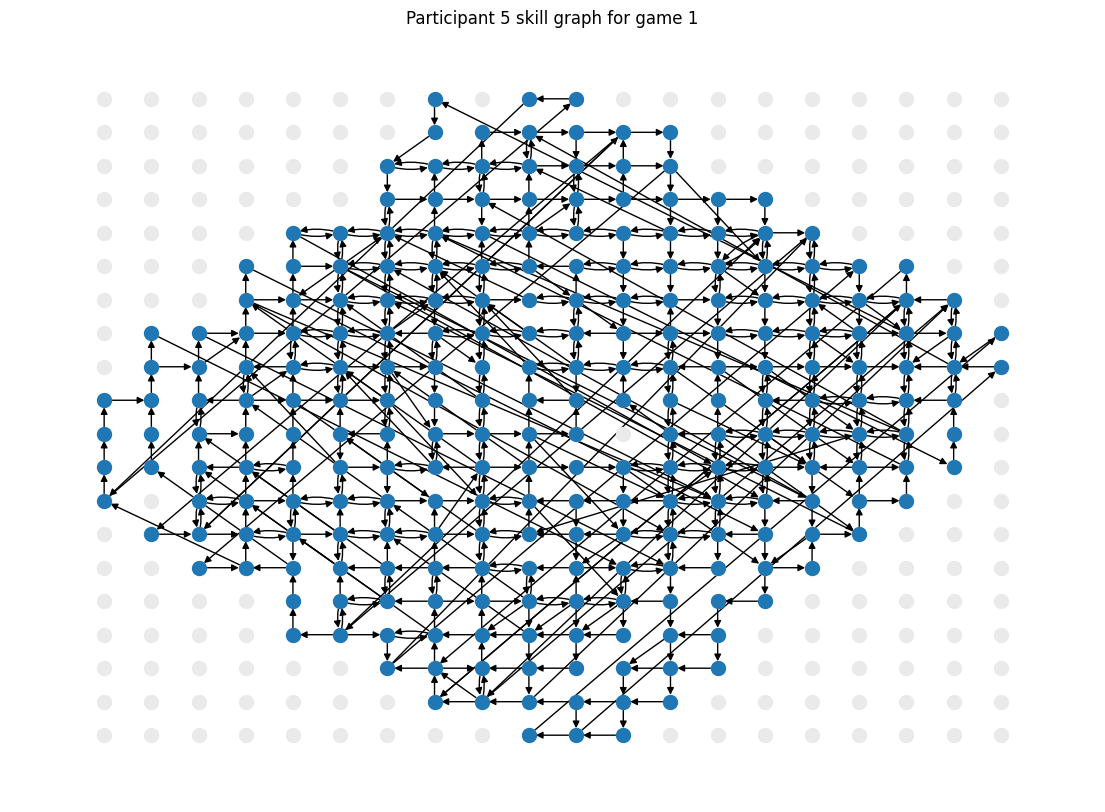

# of non-zero transition probabilities for trial last: 161
# of states visited for trial last: 48
Average non-zero transition probability: 49.06832
{((9, 5), (np.int64(9), np.int64(6))): '1', ((10, 5), (np.int64(9), np.int64(5))): '1', ((10, 5), (np.int64(9), np.int64(6))): '1', ((9, 6), (np.int64(6), np.int64(8))): '1', ((9, 6), (np.int64(6), np.int64(9))): '3', ((9, 6), (np.int64(7), np.int64(9))): '3', ((10, 6), (np.int64(7), np.int64(9))): '1', ((12, 6), (np.int64(11), np.int64(6))): '1', ((8, 7), (np.int64(6), np.int64(10))): '1', ((9, 7), (np.int64(6), np.int64(9))): '1', ((9, 7), (np.int64(6), np.int64(10))): '3', ((9, 7), (np.int64(7), np.int64(10))): '2', ((9, 7), (np.int64(8), np.int64(7))): '1', ((9, 7), (np.int64(9), np.int64(8))): '1', ((10, 7), (np.int64(7), np.int64(10))): '2', ((11, 7), (np.int64(10), np.int64(6))): '1', ((11, 7), (np.int64(10), np.int64(7))): '6', ((12, 7), (np.int64(11), np.int64(6))): '1', ((12, 7), (np.int64(12), np.int64(6))): '1', ((6, 8), (np.int

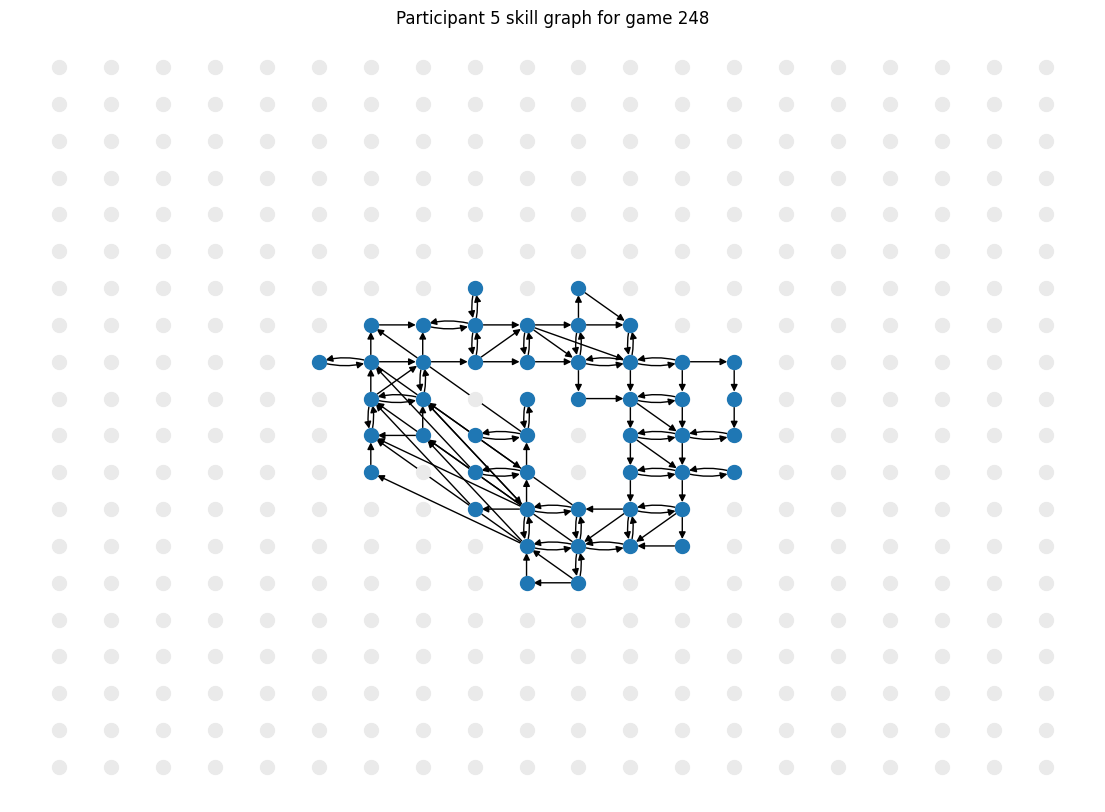

# of non-zero transition probabilities for trial first: 755
# of states visited for trial first: 245
Average non-zero transition probability: 10.46358
{((9, 0), (np.int64(8), np.int64(0))): '1', ((13, 0), (np.int64(13), np.int64(1))): '1', ((14, 0), (np.int64(13), np.int64(0))): '1', ((17, 0), (np.int64(17), np.int64(1))): '1', ((9, 1), (np.int64(9), np.int64(0))): '1', ((13, 1), (np.int64(14), np.int64(1))): '1', ((14, 1), (np.int64(15), np.int64(1))): '1', ((15, 1), (np.int64(16), np.int64(2))): '1', ((16, 1), (np.int64(16), np.int64(2))): '1', ((17, 1), (np.int64(16), np.int64(1))): '1', ((9, 2), (np.int64(9), np.int64(1))): '1', ((16, 2), (np.int64(16), np.int64(3))): '1', ((16, 2), (np.int64(17), np.int64(2))): '1', ((17, 2), (np.int64(13), np.int64(6))): '1', ((4, 3), (np.int64(4), np.int64(4))): '1', ((5, 3), (np.int64(4), np.int64(3))): '1', ((9, 3), (np.int64(9), np.int64(2))): '1', ((15, 3), (np.int64(14), np.int64(3))): '1', ((16, 3), (np.int64(15), np.int64(3))): '1', ((16,

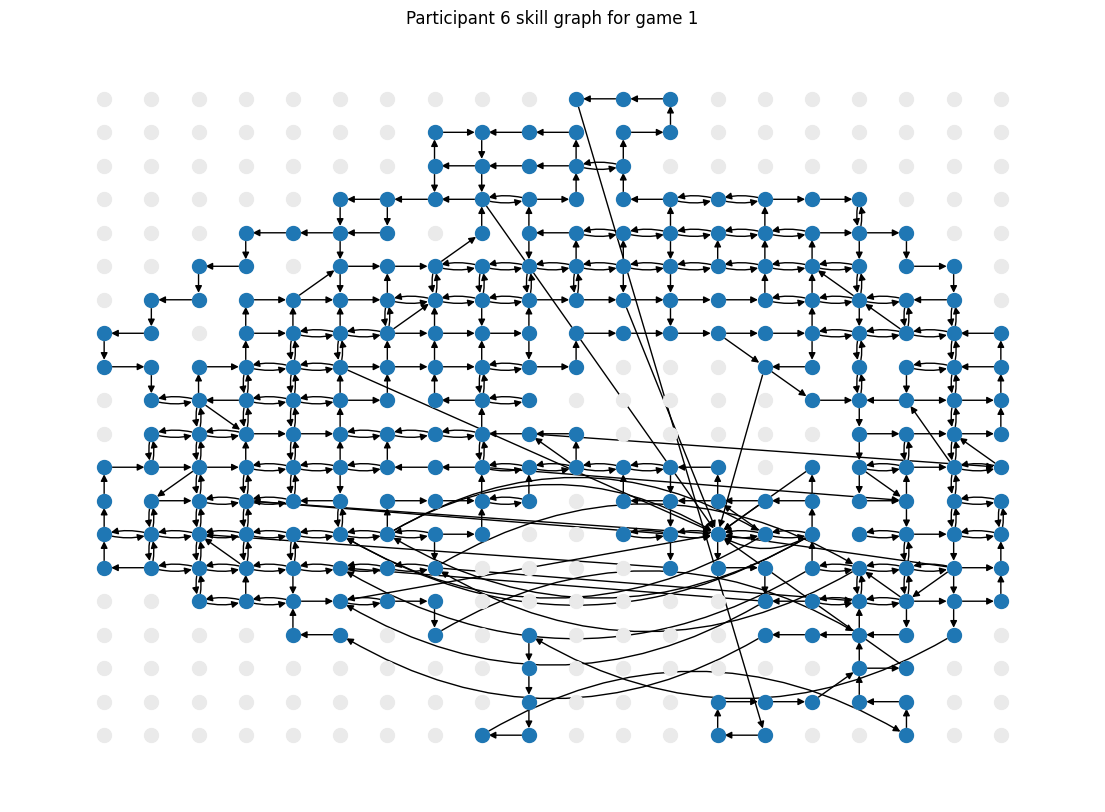

# of non-zero transition probabilities for trial last: 201
# of states visited for trial last: 59
Average non-zero transition probability: 39.30348
{((4, 6), (np.int64(4), np.int64(7))): '1', ((4, 6), (np.int64(5), np.int64(7))): '1', ((5, 6), (np.int64(4), np.int64(6))): '2', ((15, 6), (np.int64(5), np.int64(7))): '3', ((15, 6), (np.int64(6), np.int64(7))): '1', ((16, 6), (np.int64(15), np.int64(6))): '3', ((4, 7), (np.int64(5), np.int64(7))): '1', ((5, 7), (np.int64(5), np.int64(8))): '16', ((5, 7), (np.int64(6), np.int64(8))): '1', ((5, 7), (np.int64(14), np.int64(6))): '1', ((6, 7), (np.int64(6), np.int64(8))): '2', ((7, 7), (np.int64(6), np.int64(7))): '3', ((14, 7), (np.int64(5), np.int64(8))): '1', ((14, 7), (np.int64(14), np.int64(6))): '1', ((15, 7), (np.int64(15), np.int64(6))): '3', ((16, 7), (np.int64(7), np.int64(8))): '1', ((16, 7), (np.int64(16), np.int64(6))): '3', ((4, 8), (np.int64(4), np.int64(9))): '1', ((5, 8), (np.int64(4), np.int64(8))): '1', ((5, 8), (np.int64(5

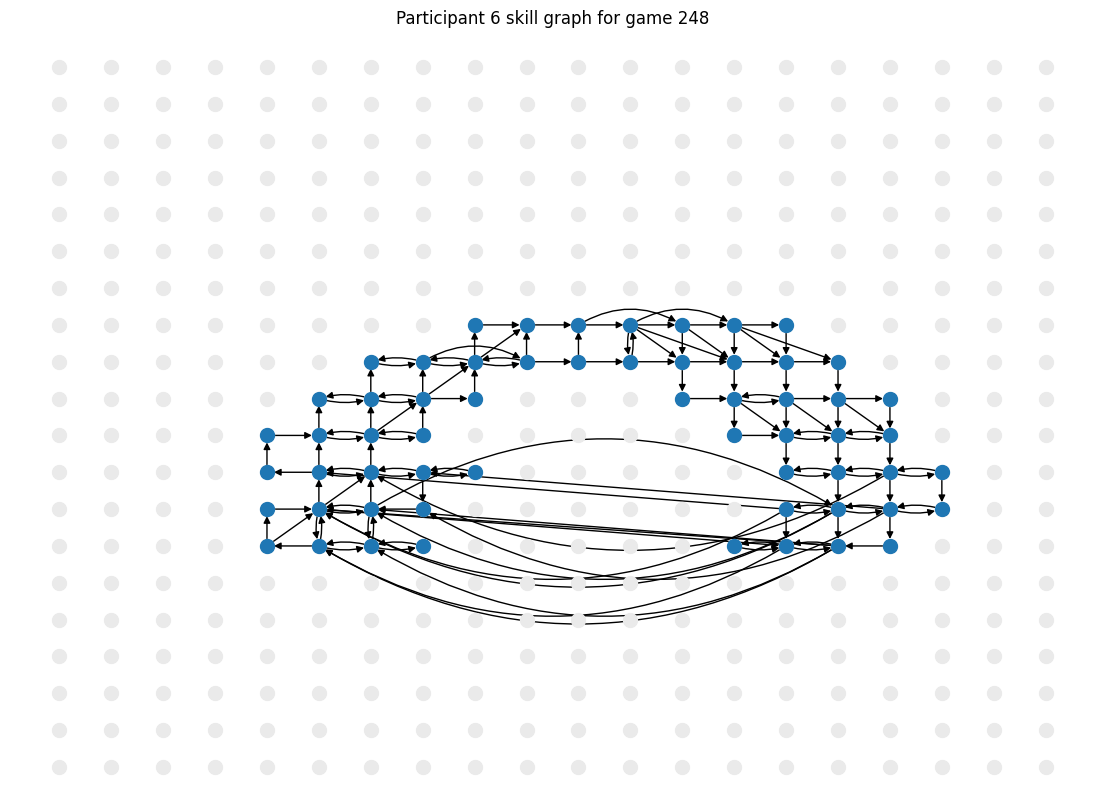

# of non-zero transition probabilities for trial first: 993
# of states visited for trial first: 325
Average non-zero transition probability: 7.95569
{((9, 0), (np.int64(10), np.int64(0))): '1', ((10, 0), (np.int64(10), np.int64(1))): '1', ((3, 1), (np.int64(3), np.int64(2))): '1', ((4, 1), (np.int64(3), np.int64(1))): '1', ((4, 1), (np.int64(5), np.int64(1))): '1', ((5, 1), (np.int64(6), np.int64(1))): '1', ((6, 1), (np.int64(6), np.int64(2))): '1', ((7, 1), (np.int64(8), np.int64(1))): '1', ((8, 1), (np.int64(9), np.int64(1))): '1', ((9, 1), (np.int64(10), np.int64(1))): '1', ((10, 1), (np.int64(10), np.int64(2))): '1', ((10, 1), (np.int64(11), np.int64(1))): '1', ((11, 1), (np.int64(12), np.int64(1))): '1', ((12, 1), (np.int64(12), np.int64(2))): '1', ((1, 2), (np.int64(1), np.int64(3))): '1', ((2, 2), (np.int64(1), np.int64(2))): '1', ((3, 2), (np.int64(2), np.int64(2))): '1', ((3, 2), (np.int64(4), np.int64(2))): '1', ((4, 2), (np.int64(4), np.int64(1))): '2', ((5, 2), (np.int64(4

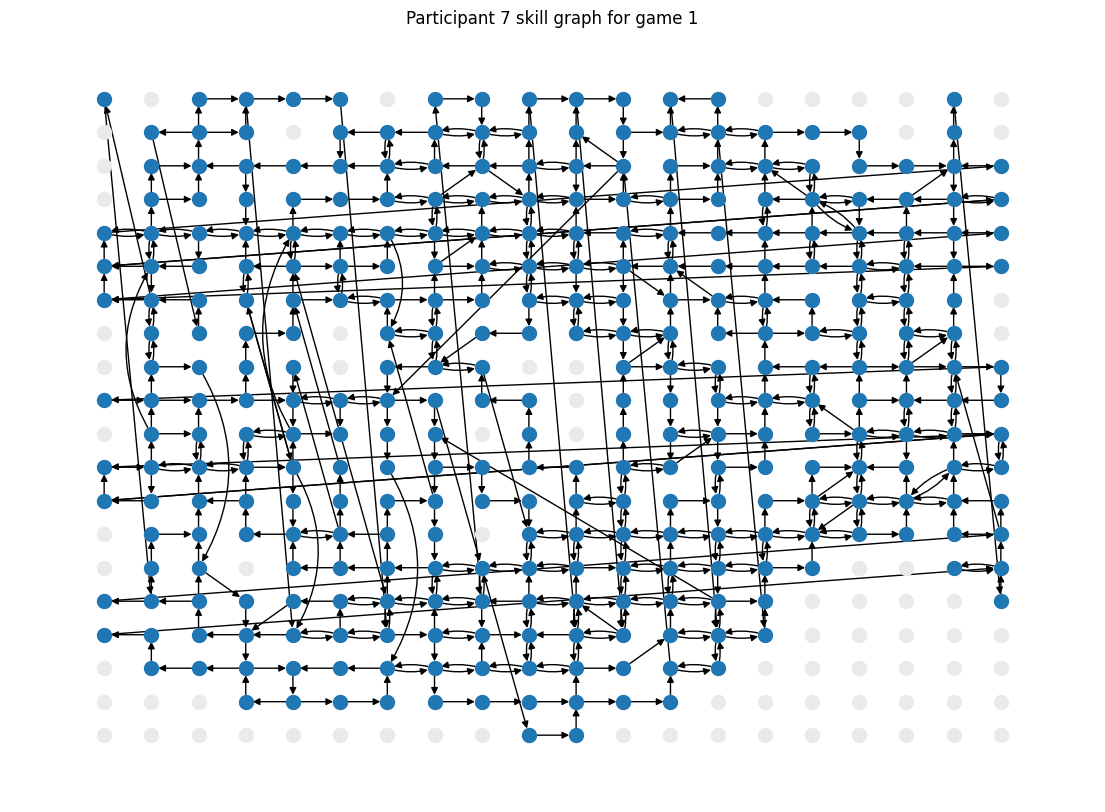

# of non-zero transition probabilities for trial last: 123
# of states visited for trial last: 39
Average non-zero transition probability: 64.22764
{((9, 6), (np.int64(8), np.int64(11))): '1', ((9, 6), (np.int64(8), np.int64(12))): '1', ((9, 6), (np.int64(10), np.int64(6))): '1', ((9, 6), (np.int64(10), np.int64(7))): '1', ((10, 6), (np.int64(10), np.int64(7))): '1', ((7, 7), (np.int64(6), np.int64(12))): '1', ((7, 7), (np.int64(8), np.int64(7))): '1', ((8, 7), (np.int64(9), np.int64(7))): '17', ((10, 7), (np.int64(11), np.int64(7))): '3', ((10, 7), (np.int64(11), np.int64(8))): '3', ((7, 8), (np.int64(7), np.int64(7))): '2', ((8, 8), (np.int64(7), np.int64(8))): '1', ((10, 8), (np.int64(11), np.int64(8))): '11', ((11, 8), (np.int64(11), np.int64(9))): '16', ((11, 8), (np.int64(12), np.int64(8))): '1', ((12, 8), (np.int64(12), np.int64(9))): '1', ((8, 9), (np.int64(8), np.int64(8))): '1', ((11, 9), (np.int64(12), np.int64(9))): '1', ((12, 9), (np.int64(11), np.int64(10))): '1', ((12, 9

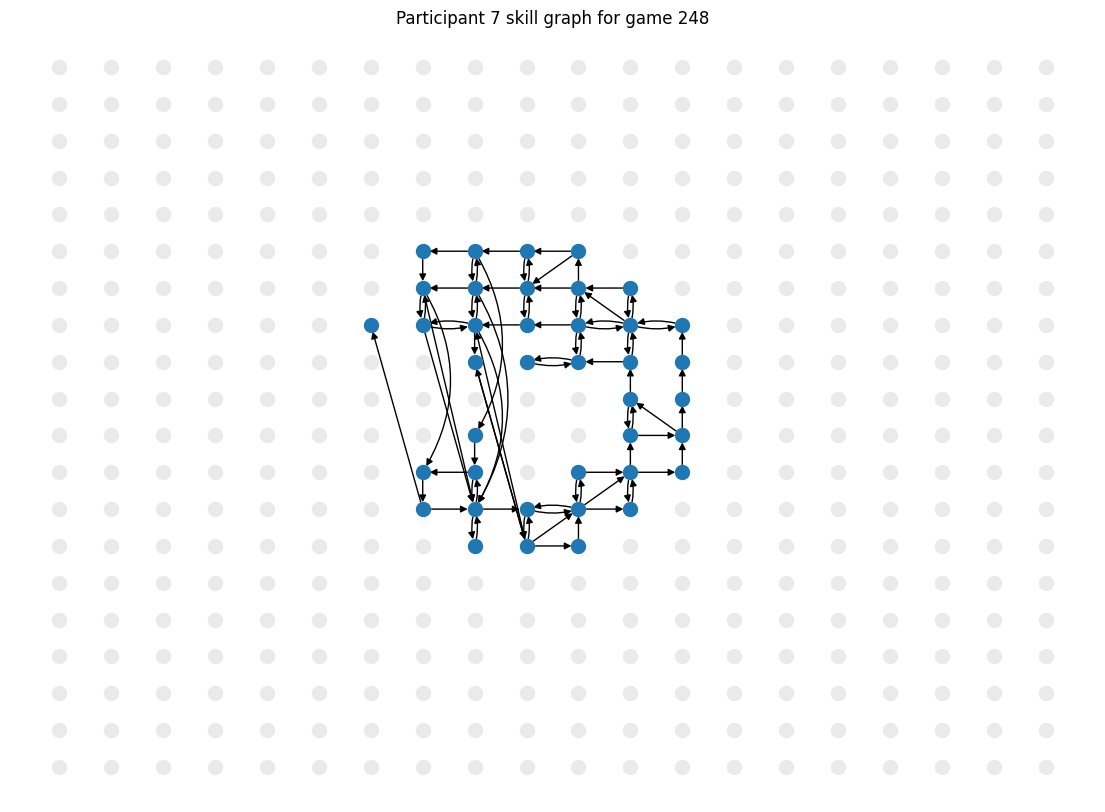

# of non-zero transition probabilities for trial first: 784
# of states visited for trial first: 256
Average non-zero transition probability: 10.07653
{((1, 0), (np.int64(3), np.int64(19))): '1', ((8, 0), (np.int64(10), np.int64(18))): '1', ((8, 0), (np.int64(10), np.int64(19))): '1', ((10, 0), (np.int64(12), np.int64(19))): '1', ((11, 0), (np.int64(10), np.int64(0))): '1', ((11, 0), (np.int64(13), np.int64(19))): '1', ((12, 0), (np.int64(14), np.int64(18))): '1', ((13, 0), (np.int64(12), np.int64(0))): '1', ((0, 1), (np.int64(2), np.int64(19))): '1', ((1, 1), (np.int64(1), np.int64(0))): '1', ((7, 1), (np.int64(8), np.int64(1))): '1', ((8, 1), (np.int64(8), np.int64(0))): '1', ((9, 1), (np.int64(8), np.int64(0))): '1', ((11, 1), (np.int64(11), np.int64(0))): '2', ((12, 1), (np.int64(11), np.int64(1))): '1', ((13, 1), (np.int64(13), np.int64(0))): '1', ((13, 1), (np.int64(14), np.int64(1))): '1', ((14, 1), (np.int64(14), np.int64(2))): '1', ((0, 2), (np.int64(0), np.int64(1))): '1', ((

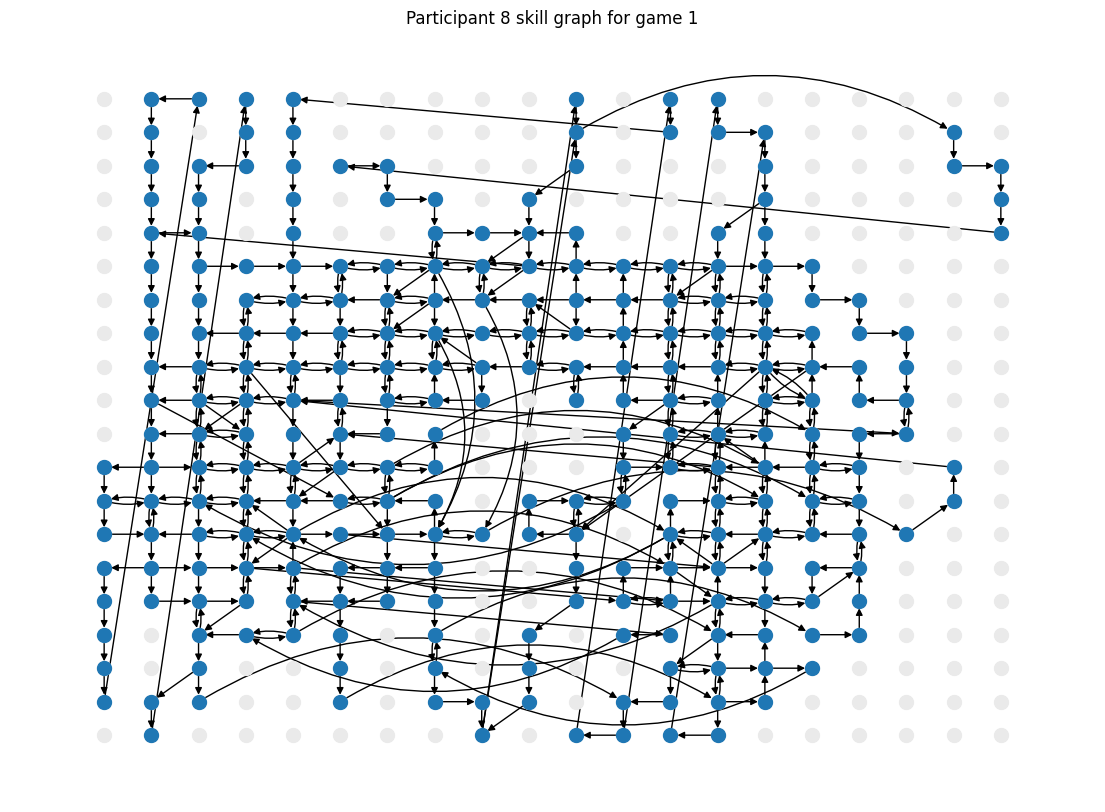

# of non-zero transition probabilities for trial last: 289
# of states visited for trial last: 78
Average non-zero transition probability: 27.33564
{((13, 5), (np.int64(14), np.int64(5))): '1', ((14, 5), (np.int64(12), np.int64(8))): '1', ((4, 6), (np.int64(13), np.int64(5))): '1', ((6, 6), (np.int64(5), np.int64(6))): '1', ((11, 6), (np.int64(12), np.int64(6))): '1', ((12, 6), (np.int64(4), np.int64(8))): '1', ((13, 6), (np.int64(13), np.int64(7))): '1', ((5, 7), (np.int64(5), np.int64(8))): '1', ((11, 7), (np.int64(11), np.int64(6))): '1', ((12, 7), (np.int64(4), np.int64(8))): '1', ((12, 7), (np.int64(12), np.int64(6))): '1', ((12, 7), (np.int64(13), np.int64(8))): '1', ((4, 8), (np.int64(12), np.int64(7))): '1', ((4, 8), (np.int64(13), np.int64(7))): '1', ((10, 8), (np.int64(11), np.int64(7))): '1', ((11, 8), (np.int64(3), np.int64(9))): '1', ((11, 8), (np.int64(11), np.int64(9))): '2', ((13, 8), (np.int64(14), np.int64(7))): '1', ((13, 8), (np.int64(14), np.int64(8))): '1', ((14, 

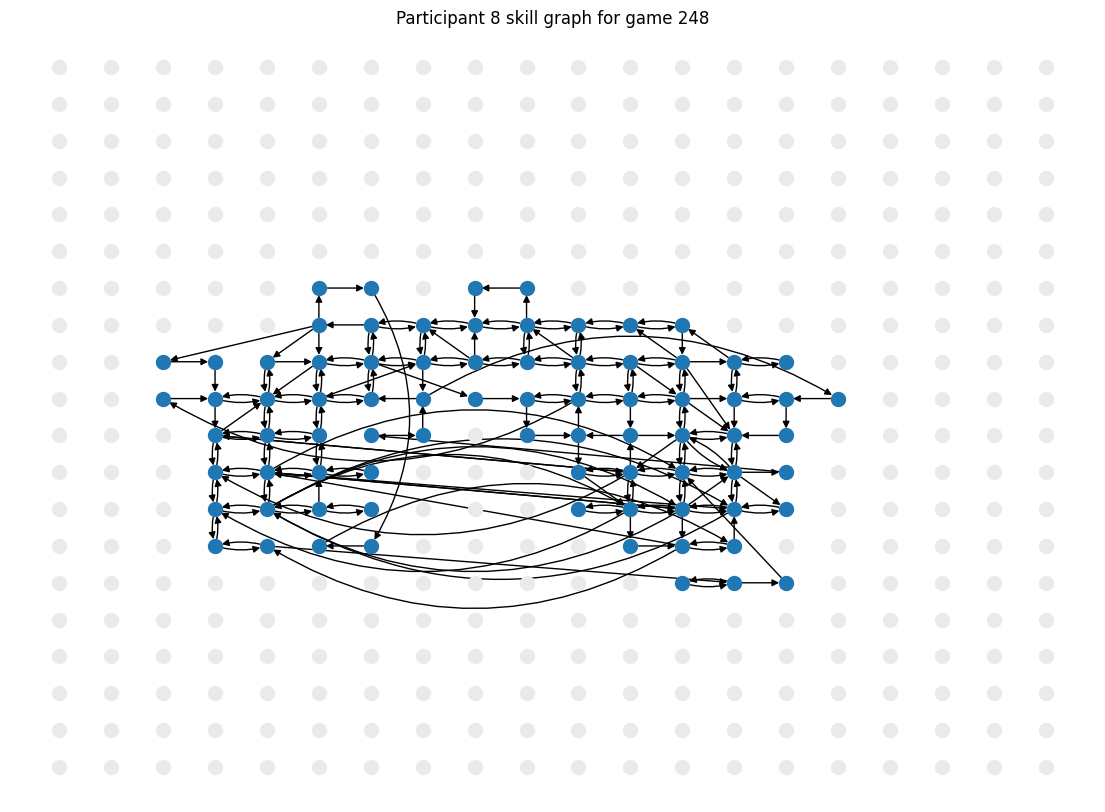

# of non-zero transition probabilities for trial first: 1031
# of states visited for trial first: 306
Average non-zero transition probability: 7.66246
{((9, 0), (np.int64(10), np.int64(0))): '1', ((10, 0), (np.int64(5), np.int64(18))): '1', ((10, 0), (np.int64(10), np.int64(1))): '2', ((11, 0), (np.int64(10), np.int64(0))): '1', ((11, 0), (np.int64(11), np.int64(1))): '2', ((12, 0), (np.int64(12), np.int64(1))): '1', ((5, 1), (np.int64(6), np.int64(1))): '1', ((6, 1), (np.int64(7), np.int64(1))): '1', ((7, 1), (np.int64(12), np.int64(2))): '1', ((9, 1), (np.int64(9), np.int64(2))): '1', ((10, 1), (np.int64(9), np.int64(1))): '1', ((10, 1), (np.int64(10), np.int64(2))): '2', ((11, 1), (np.int64(10), np.int64(1))): '1', ((11, 1), (np.int64(10), np.int64(2))): '1', ((11, 1), (np.int64(11), np.int64(2))): '1', ((12, 1), (np.int64(11), np.int64(1))): '1', ((12, 1), (np.int64(12), np.int64(2))): '1', ((12, 1), (np.int64(13), np.int64(1))): '1', ((13, 1), (np.int64(8), np.int64(19))): '1', ((

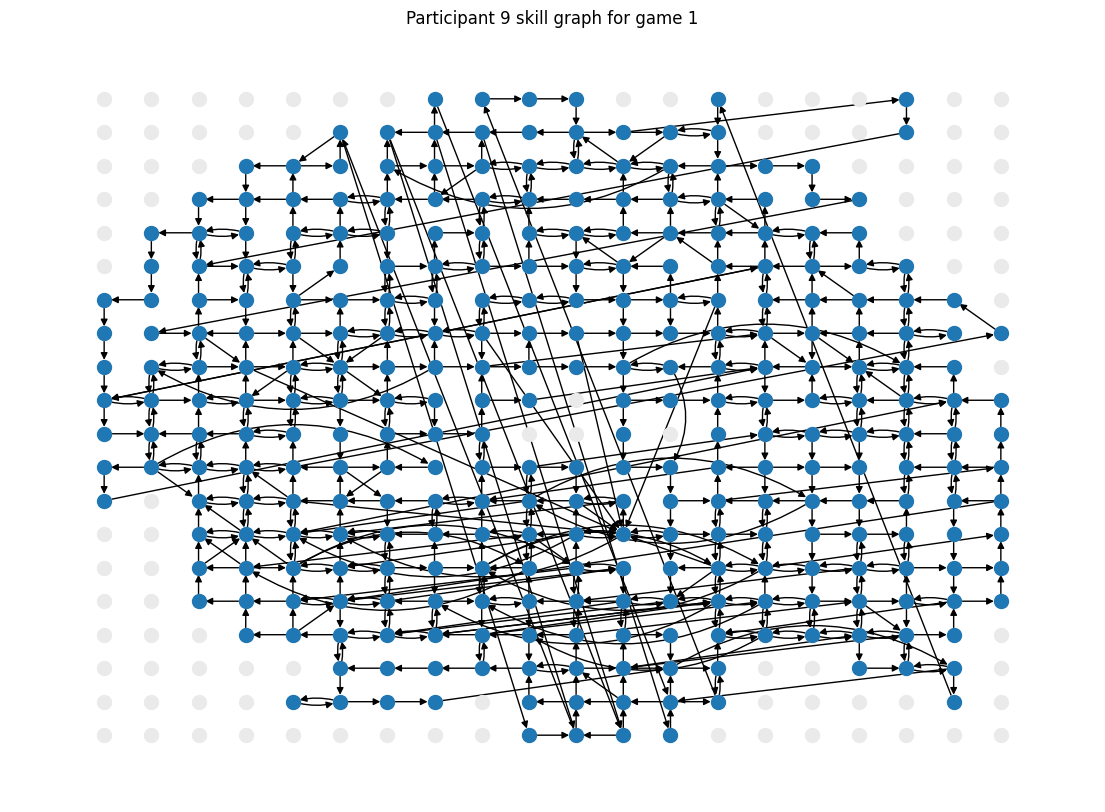

# of non-zero transition probabilities for trial last: 210
# of states visited for trial last: 63
Average non-zero transition probability: 37.61905
{((5, 6), (np.int64(5), np.int64(7))): '2', ((6, 6), (np.int64(5), np.int64(6))): '1', ((7, 6), (np.int64(7), np.int64(7))): '1', ((5, 7), (np.int64(5), np.int64(8))): '1', ((6, 7), (np.int64(6), np.int64(8))): '21', ((7, 7), (np.int64(6), np.int64(6))): '1', ((8, 7), (np.int64(7), np.int64(7))): '1', ((9, 7), (np.int64(14), np.int64(8))): '1', ((10, 7), (np.int64(5), np.int64(6))): '1', ((11, 7), (np.int64(6), np.int64(6))): '1', ((11, 7), (np.int64(11), np.int64(8))): '1', ((12, 7), (np.int64(7), np.int64(6))): '2', ((12, 7), (np.int64(11), np.int64(7))): '3', ((13, 7), (np.int64(7), np.int64(6))): '2', ((13, 7), (np.int64(13), np.int64(6))): '1', ((14, 7), (np.int64(13), np.int64(7))): '1', ((5, 8), (np.int64(5), np.int64(9))): '4', ((5, 8), (np.int64(6), np.int64(9))): '1', ((6, 8), (np.int64(6), np.int64(9))): '17', ((11, 8), (np.int64

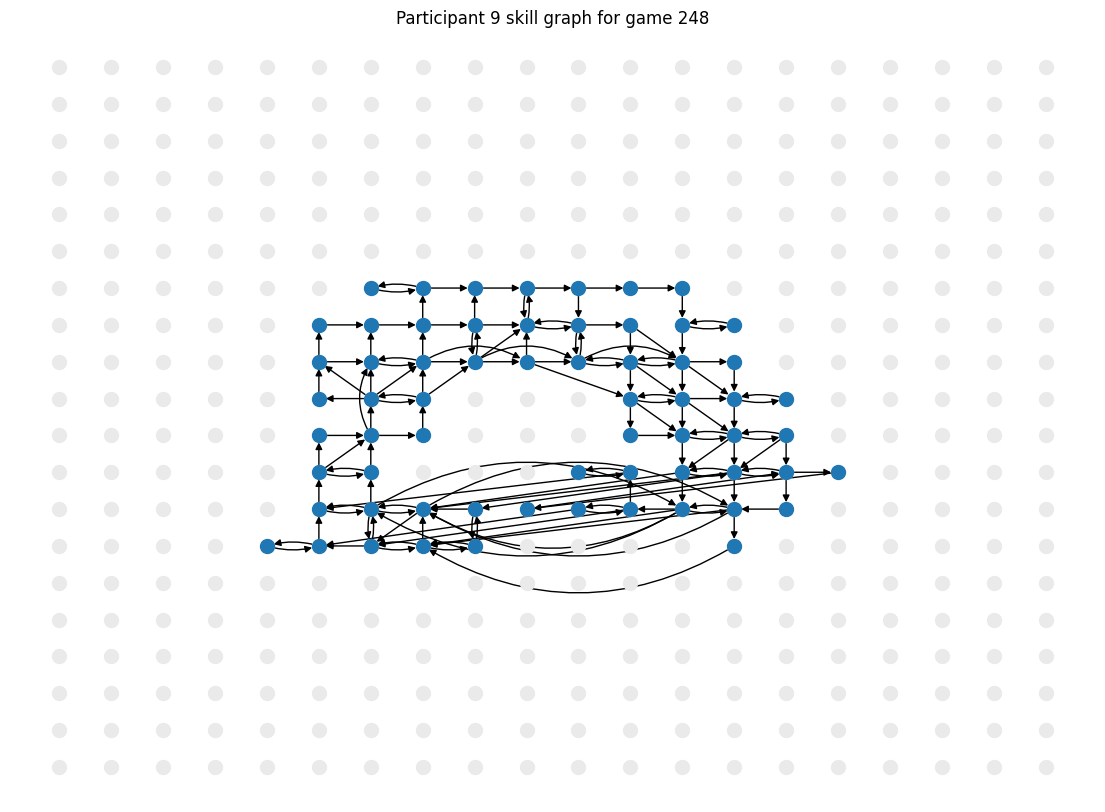

In [53]:
subj_nums = [(i, subj) for (i, subj) in enumerate(sf_subjects)]

plot_markov_chains(subjects=subj_nums, transitions_mat=sf_transitions_mat, df=sf_pca_df, all_subj_info=sf_all_subj_info,
                  #  wt_add_color=0, wt_mult_color=1, wt_power_color=1,
                   wt_add_width=1, wt_mult_width=.001, wt_power_width=1, wt_alpha=1,
                   label_pos=0.5, vertical_alignment='center', horizontal_alignment='center',
                   label_alpha=1, node_size=100, wt_labels=False, unused_nodes_color='#eaeaea',
                   path_nodes_color='#1f77b4', figsize=(14,10), bg_color='white', arc_rad_adj=0.15,
                   arc_rad_across=-0.3, arrow_size=10, font_size=10, alpha_self_loops=1,
                   label_pos_straight_edges=0.6, label_pos_self_loops=0.6,
                   vertical_alignment_straight_edges='top', horizontal_alignment_straight_edges='center',
                   vertical_alignment_self_loops='top', horizontal_alignment_self_loops='right',
                   with_node_labels=False)